# Imports

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.5 MB/s eta 0:00:00


In [ ]:
!pip install ray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 21.7 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.54.0
    Uninstalling grpcio-1.54.0:
      Successfully uninstalled grpcio-1.54.0


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

In [ ]:
from torch import nn
import torch.jit as jit
import torch.nn.functional as F
import numpy as np
from ray import tune

In [ ]:
from datetime import datetime

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
torch.autograd.set_detect_anomaly(True)

# NN classes

## Models and custom cells

In [ ]:
class Trainer:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        self.model.train()
        yhat = self.model(x)
        loss = self.loss_fn(y, yhat)
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        # torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
      with torch.no_grad():
          predictions = []
          values = []
          for x_test, y_test in test_loader:
              x_test = x_test.view([batch_size, -1, n_features]).to(device)
              y_test = y_test.to(device)
              self.model.eval()
              yhat = self.model(x_test)
              predictions.append(yhat.detach().cpu().numpy())
              values.append(y_test.detach().cpu().numpy())

      return predictions, values

    def evaluateFromArrays(self, X, y, n_features=1):
      X = torch.Tensor(X)
      y = torch.Tensor(y)
      with torch.no_grad():
          prediction = None
          real = None
          x_test = X.view([1, -1, n_features]).to(device)
          y_test = y.to(device)
          self.model.eval()
          yhat = self.model(x_test)
          prediction = yhat.detach().cpu().numpy()
          real = y_test.detach().cpu().numpy()

      return prediction[0], real

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [ ]:
class RNNModel(nn.Module):
    """
    Classic RNN model
    """
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, h0 = self.rnn(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        out, _ = self.gru(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)

        return out

ResLSTM

In [ ]:
class ResLSTMLayer(nn.Module):
    """
    For this layer input_dim = hidden_dim = output_dim
    """
    def __init__(self, input_dim, dimension, layer_dim, dropout_prob, batch_first=True):
        super(ResLSTMLayer, self).__init__()
        # print("Creating Residual LSTM", input_dim, dimension, layer_dim, dropout_prob)
        # LSTM layers
        self.lstm = nn.LSTM(input_dim, dimension, layer_dim, batch_first=batch_first, dropout=dropout_prob)
        self.lstm.to(device)

    def forward(self, x, bus):
        # print("forwarding inside residual layer")
        # print(x, h, c)
        h = bus[0]
        c = bus[1]
        out, (hn, cn) = self.lstm(x, (h, c))
        out = out + x

        return [out, (hn, cn)]

In [ ]:
class ResLSTMModel(nn.Module):
    """
    Basic residual LSTM model
    input_dim - dimension of input
    hidden_dim - dimension of hidden layers
    layer_dim - layers count between shortcut connections
    layers_count - count of residual blocks
    output_dim - dimension of output
    dropout_prob - dropout probability on each layer
    """
    def __init__(self, input_dim, hidden_dim, layer_dim, layers_count, output_dim, dropout_prob):
        super(ResLSTMModel, self).__init__()
        # print("Creating Residual LSTM model", input_dim, hidden_dim, layer_dim, layers_count, output_dim, dropout_prob)

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.shortcut_layer_dim = layer_dim
        self.layer_dim = layer_dim

        self.layers = []
        reslstm = nn.LSTM(input_dim, hidden_dim, layer_dim, dropout=dropout_prob, batch_first=True)
        reslstm.to(device)
        self.layers.append(reslstm)
        for i in range(layers_count-1):
          reslstm = ResLSTMLayer(hidden_dim, hidden_dim, layer_dim, dropout_prob, batch_first=True)
          reslstm.to(device)
          self.layers.append(reslstm)

        # final lstm layer
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, layer_dim, dropout=dropout_prob, batch_first=True)
        self.lstm.to(device)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)

        for layer in self.layers:
          # print("forwarding full layer")
          x, bus = layer(x, (h0.detach(), c0.detach()))
          h0, c0 = bus[0], bus[1]
          

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = out[:, -1, :]
        out = self.fc(out)

        return out

## Ensembles

Stack creator

In [ ]:
class Stack(nn.Module):
    def __init__(self, models, hidden_dim, output_dim, disable_grad_f):
        super(Stack,self).__init__()
        self.models = list(map(disable_grad_f, models))
        
        self.l_in = nn.Linear(len(self.models)*output_dim, hidden_dim, bias=False)        
        self.l_out = nn.Linear(hidden_dim, output_dim, bias=False)

        print("models count in stack:", len(self.models))
          
    def forward(self,x):
      outputs = []
      for net in self.models: outputs.append(net(x))
      # print(len(outputs), outputs[0].shape)
      out = torch.cat(outputs, 1)
      out1 = F.relu(self.l_in(out))
      out2 = self.l_out(out1)
      return out2

Averaging ensemble

In [ ]:
from functools import reduce

In [ ]:
class SumEnsemble(nn.Module):
    def __init__(self, models, hidden_dim, output_dim, disable_grad_f):
        super(SumEnsemble, self).__init__()
        self.models = list(map(disable_grad_f, models))

        self.l_in = nn.Linear(output_dim, hidden_dim, bias=False)  
        self.l_out = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, x):
        outputs = []
        for net in self.models: outputs.append(net(x))
        out = reduce(lambda x, y: x+y, outputs)
        out1 = F.relu(self.l_in(out))
        out2 = self.l_out(out1)
        return out2

# Helper functions

In [ ]:
!mkdir models

In [ ]:
def createDataset(dataset, input_n, horizon):
    X, y, div = [], [], []
    for i in range(len(dataset)-horizon-input_n):
        # print(f"x: {i}:{i+input_n}; y: {i+input_n}:{i+input_n+horizon}")
        feature = dataset.iloc[i:i+input_n]
        target = dataset.iloc[i+input_n:i+input_n+horizon]
        # print(feature, "=>", target)
        div.append(feature.iloc[-1].value)
        # target = target / feature.iloc[-1]
        # feature = feature / feature.iloc[-1]
        X.append(feature["value"].values)
        y.append(target["value"].values)
    X, y = pd.DataFrame(X, columns =[f"I{i}" for i in range(input_n)]), pd.DataFrame(y, columns =[f"H{i}" for i in range(horizon)])
    return (X, y, div)

def train_val_test_split(X, y, val_ratio):
    X_test, y_test = X.iloc[-1], y.iloc[-1]
    X_train, X_val, y_train, y_val = train_test_split(X.iloc[:-1], y.iloc[:-1], test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler=None, concat=None):
    if concat is not None:
      values = np.concatenate(values, axis=concat).ravel()
      predictions = np.concatenate(predictions, axis=concat).ravel()
    df_result = pd.DataFrame(data={"value": values, "prediction": predictions}, index=df_test.head(len(values)).index)
    df_result = df_result.sort_index()
    if scaler is not None: df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result

def calculate_metrics(df):
    return{
        'mae' : mean_absolute_error(df.value, df.prediction),
        'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5
    }
            # 'r2' : r2_score(df.value, df.prediction)}

In [ ]:
def scaleData(scaler, X_train, X_val, X_test, y_train, y_val, y_test):
  X_train_arr = scaler.fit_transform(X_train)
  X_val_arr = scaler.transform(X_val)
  X_test_arr = scaler.transform(X_test)

  y_train_arr = scaler.fit_transform(y_train)
  y_val_arr = scaler.transform(y_val)
  y_test_arr = scaler.transform(y_test)
  return (X_train_arr, X_val_arr, X_test_arr, y_train_arr, y_val_arr, y_test_arr)

In [ ]:
def createTrainers(X_train_arr, y_train_arr, X_val_arr, y_val_arr, batch_size):
  train_features = torch.Tensor(X_train_arr)
  train_targets = torch.Tensor(y_train_arr)
  val_features = torch.Tensor(X_val_arr)
  val_targets = torch.Tensor(y_val_arr)

  train = TensorDataset(train_features, train_targets)
  val = TensorDataset(val_features, val_targets)

  train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
  val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)

  return (train_loader, val_loader)

# Data

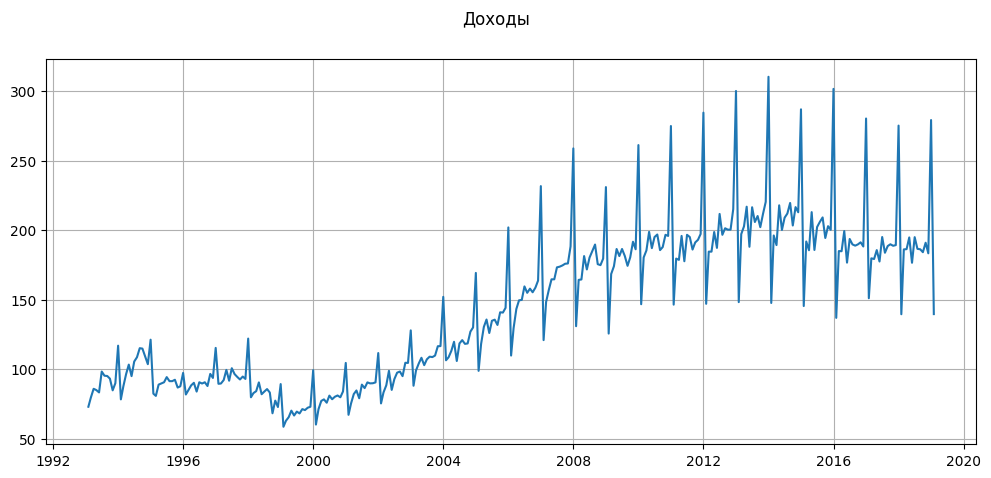

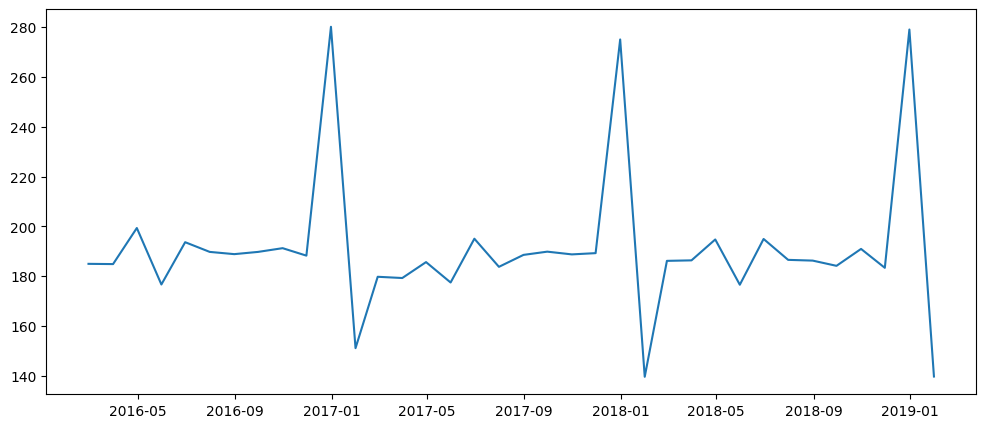

In [ ]:
dohody = pd.read_table('денежные доходы.txt', delimiter ='\t', header = None)
dohody[0] = pd.date_range(start='1/1993', end= '2/2019', freq = 'M')
dohody = dohody.set_index([0])
dohody = dohody.drop(dohody.columns[[1, 2]],axis = 1)
dohody = dohody.rename(columns={1: 'value'})

plt.figure(figsize=(12, 5))
plt.plot(dohody)
plt.suptitle('Доходы')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(dohody.tail(36))
plt.show()

Lets deseason data

In [ ]:
df = dohody

In [ ]:
# Trend, seasional and residual values
res = STL(df, period = 12).fit()
trend = res.trend
seasonal = res.seasonal
residual = res.resid
deseasoned = trend + residual

In [ ]:
scaler = MinMaxScaler()
scaler.fit(deseasoned.values.reshape(-1, 1))
df = pd.DataFrame(np.transpose([deseasoned.index, scaler.transform(deseasoned.values.reshape(-1, 1)).reshape(313,)]), columns=["Datetime", "value"])
df = df.set_index(['Datetime'])
df.index = pd.to_datetime(df.index)
if not df.index.is_monotonic:
    df = df.sort_index()

<ipython-input-30-57f707be0ebc>:6: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not df.index.is_monotonic:


In [ ]:
df["value"]

Datetime
1993-01-31    0.158857
1993-02-28    0.158699
1993-03-31     0.15074
1993-04-30    0.141488
1993-05-31    0.153415
                ...   
2018-09-30    0.796674
2018-10-31     0.82752
2018-11-30    0.809676
2018-12-31    0.824923
2019-01-31    0.791218
Name: value, Length: 313, dtype: object

In [ ]:
input_dim = 36
outpur_dim = 12
X, y, div = createDataset(df, input_dim, outpur_dim)

In [ ]:
# X = X.applymap(np.log)
# y = y.applymap(np.log)
X

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,I26,I27,I28,I29,I30,I31,I32,I33,I34,I35
0,0.158857,0.158699,0.150740,0.141488,0.153415,0.171047,0.159460,0.143312,0.135448,0.143380,...,0.172206,0.157555,0.194402,0.163507,0.152016,0.143481,0.159430,0.132914,0.145536,0.078093
1,0.158699,0.150740,0.141488,0.153415,0.171047,0.159460,0.143312,0.135448,0.143380,0.168134,...,0.157555,0.194402,0.163507,0.152016,0.143481,0.159430,0.132914,0.145536,0.078093,0.172335
2,0.150740,0.141488,0.153415,0.171047,0.159460,0.143312,0.135448,0.143380,0.168134,0.209185,...,0.194402,0.163507,0.152016,0.143481,0.159430,0.132914,0.145536,0.078093,0.172335,0.180199
3,0.141488,0.153415,0.171047,0.159460,0.143312,0.135448,0.143380,0.168134,0.209185,0.179012,...,0.163507,0.152016,0.143481,0.159430,0.132914,0.145536,0.078093,0.172335,0.180199,0.170038
4,0.153415,0.171047,0.159460,0.143312,0.135448,0.143380,0.168134,0.209185,0.179012,0.207902,...,0.152016,0.143481,0.159430,0.132914,0.145536,0.078093,0.172335,0.180199,0.170038,0.154537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.942383,0.970744,0.933685,0.839681,0.911056,0.912431,0.888858,0.928545,0.890822,0.891660,...,0.809170,0.815866,0.900676,0.806323,0.806336,0.774053,0.828836,0.827685,0.798264,0.818356
261,0.970744,0.933685,0.839681,0.911056,0.912431,0.888858,0.928545,0.890822,0.891660,0.922122,...,0.815866,0.900676,0.806323,0.806336,0.774053,0.828836,0.827685,0.798264,0.818356,0.836921
262,0.933685,0.839681,0.911056,0.912431,0.888858,0.928545,0.890822,0.891660,0.922122,0.917001,...,0.900676,0.806323,0.806336,0.774053,0.828836,0.827685,0.798264,0.818356,0.836921,0.805463
263,0.839681,0.911056,0.912431,0.888858,0.928545,0.890822,0.891660,0.922122,0.917001,0.874990,...,0.806323,0.806336,0.774053,0.828836,0.827685,0.798264,0.818356,0.836921,0.805463,0.832591


In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
print(list(map(len, (X_train, X_val, X_test, y_train, y_val, y_test))))
# scaler = MinMaxScaler()
# X_train_arr, X_val_arr, y_train_arr, y_val_arr = scaleData(scaler, X_train, X_val, y_train, y_val)
# batch_size = 32
# train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

[211, 53, 36, 211, 53, 12]


# ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [ ]:
x_train = df[:-12]

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(x_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q = 3, m = 12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.95 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-921.097, Time=0.33 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1054.378, Time=1.43 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.67 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-951.070, Time=0.17 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1110.787, Time=2.47 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=7.17 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=5.08 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-1071.910, Time=3.45 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-1131.228, Time=3.94 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-1069.235, Time=2.03 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=7.14 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=2.79 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-1129.619, Time=1.35 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=

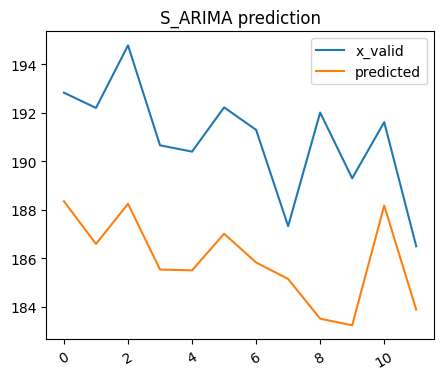

{'mae': 5.0156979789008345, 'rmse': 5.281440282935641}


In [ ]:
# Forecast
fitted, confint = smodel.predict(12, return_conf_int = True)

# make series for plotting purpose
fitted_series = pd.Series(fitted)
lower_series = pd.Series(confint[:, 0])
upper_series = pd.Series(confint[:, 1])

fitted = scaler.inverse_transform(fitted.values.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(df[-12:].values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(fitted, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("S_ARIMA prediction")
plt.show()

print(
    {
        'mae' : mean_absolute_error(values, fitted),
        'rmse' : mean_squared_error(values, fitted) ** 0.5
    }
)

# ETS

In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


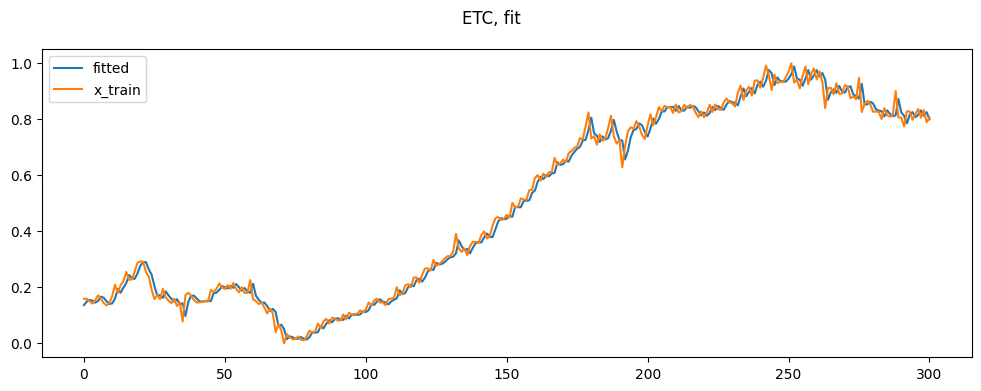

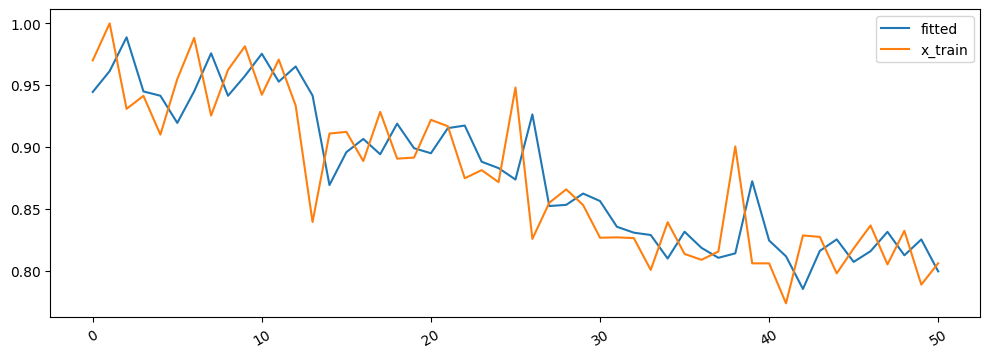

In [ ]:
model = ETSModel(x_train.values.reshape(-1),
                seasonal='add',
                seasonal_periods=12)
fit = model.fit(maxiter = 10)

# spots.plot(label="data")
fitted = fit.fittedvalues

plt.figure(figsize = (12, 4))
plt.plot(fitted, label = 'fitted')
plt.plot(x_train.values.reshape(-1), label = 'x_train')
plt.suptitle('ETC, fit')
plt.legend()
plt.show()

offset = 250
plt.figure(figsize = (12, 4))
plt.plot(fitted[offset: ], label = 'fitted')
plt.plot(x_train.values.reshape(-1)[offset: ], label = 'x_train')
plt.tick_params(axis = 'x', labelrotation = 30)
plt.legend()
plt.show()



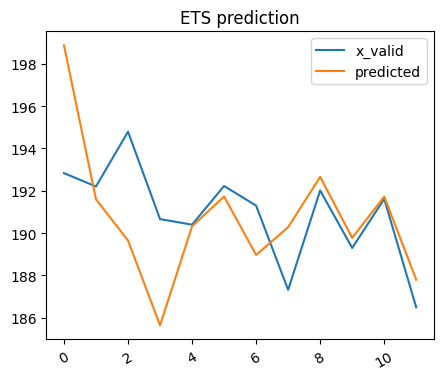

{'mae': 2.099782700602302, 'rmse': 2.960423924490046}


In [ ]:
fitted = fit.predict()[-12:]
fitted = scaler.inverse_transform(fitted.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(df[-12:].values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(fitted, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ETS prediction")
plt.show()

print(
    {
        'mae' : mean_absolute_error(values, fitted),
        'rmse' : mean_squared_error(values, fitted) ** 0.5
    }
)

# Tuning Basic

## Grid search on LSTM

In [ ]:
config = {
    "learning_rate":  tune.grid_search([1e-4, 1e-3, 1e-2]),
    "batch_size": tune.grid_search([8, 16, 32]),
    "input_dim": tune.grid_search([12, 24, 36]),
    "hidden_dim": tune.grid_search([96, 128, 512]),
    "layer_dim" : tune.grid_search([3, 4, 5]),
    "dropout" : tune.grid_search([0.1, 0.2]),
    "delta": tune.grid_search([1.0, 1.5])
}


In [ ]:
def train_wrapper(config):
  input_dim = config["input_dim"]
  output_dim = 12
  X, y, div = createDataset(df, input_dim, output_dim)
  X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
  train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, config["batch_size"])

  n_epochs = 12
  weight_decay = 1e-6

  model_params = {
      'input_dim': input_dim,
      'output_dim' : output_dim,
      'hidden_dim' : config["hidden_dim"],
      'layer_dim' : config["layer_dim"],
      'dropout_prob' : config["dropout"]
}

  model = LSTMModel(**model_params)

  # loss_fn = nn.MSELoss(reduction="mean")
  loss_fn = nn.HuberLoss(reduction='mean', delta=config["delta"])
  # loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=weight_decay)

  opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=config["batch_size"], n_epochs=n_epochs, n_features=input_dim)
  predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

  predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
  values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
  # print("PRED:", predictions)
  # print("REAL:", values)
  df_result = format_predictions(predictions, values, X_test)
  result_metrics = calculate_metrics(df_result)
  tune.report(accuracy=result_metrics["mae"])

In [ ]:
analysis = tune.run(
  train_wrapper,
  config=config,
  resources_per_trial={"cpu": 2, "gpu": 1},
)
best_trial = analysis.get_best_trial("accuracy", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation accuracy (MAE): {}".format(
    best_trial.last_result["accuracy"]))

2023-04-29 17:20:11,865	INFO worker.py:1625 -- Started a local Ray instance.
2023-04-29 17:20:14,166	INFO tune.py:218 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2023-04-29 17:20:14,310	INFO tensorboardx.py:172 -- pip install "ray[tune]" to see TensorBoard files.
2023-04-29 17:20:14,311	WARNING callback.py:142 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(train_wrapper pid=9381) [1/12] Training loss: 0.1300	 Validation loss: 0.3791
(train_wrapper pid=9381) [2/12] Training loss: 0.1257	 Validation loss: 0.3698
(train_wrapper pid=9381) [3/12] Training loss: 0.1211	 Validation loss: 0.3587
(train_wrapper pid=9381) [4/12] Training loss: 0.1154	 Validation loss: 0.3436
(train_wrapper pid=9381) [5/12] Training loss: 0.1076	 Validation loss: 0.3210
(train_wrapper pid=9381) [6/12] Training loss: 0.0963	 Validation loss: 0.2855
(train_wrapper pid=9381) [7/12] Training loss: 0.0799	 Validation loss: 0.2305
(train_wrapper pid=9381) [8/12] Training loss: 0.0579	 Validation loss: 0.1555
(train_wrapper pid=9381) [9/12] Training loss: 0.0343	 Validation loss: 0.0772
(train_wrapper pid=9381) [10/12] Training loss: 0.0180	 Validation loss: 0.0260


Trial name,accuracy,date,done,experiment_tag,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_wrapper_1a980_00000,8.60185,2023-04-29_17-20-25,True,"0_batch_size=8,delta=1.0000,dropout=0.1000,hidden_dim=96,input_dim=12,layer_dim=3,learning_rate=0.0001",cbb931020cc0,1,172.28.0.12,9381,1.17497,1.17497,1.17497,1682788825,1,1a980_00000
train_wrapper_1a980_00001,104.424,2023-04-29_17-20-30,True,"1_batch_size=16,delta=1.0000,dropout=0.1000,hidden_dim=96,input_dim=12,layer_dim=3,learning_rate=0.0001",cbb931020cc0,1,172.28.0.12,9467,0.739836,0.739836,0.739836,1682788830,1,1a980_00001
train_wrapper_1a980_00002,121.147,2023-04-29_17-20-36,True,"2_batch_size=32,delta=1.0000,dropout=0.1000,hidden_dim=96,input_dim=12,layer_dim=3,learning_rate=0.0001",cbb931020cc0,1,172.28.0.12,9531,0.533689,0.533689,0.533689,1682788836,1,1a980_00002
train_wrapper_1a980_00003,11.5798,2023-04-29_17-20-42,True,"3_batch_size=8,delta=1.5000,dropout=0.1000,hidden_dim=96,input_dim=12,layer_dim=3,learning_rate=0.0001",cbb931020cc0,1,172.28.0.12,9604,1.15159,1.15159,1.15159,1682788842,1,1a980_00003
train_wrapper_1a980_00004,105.93,2023-04-29_17-20-49,True,"4_batch_size=16,delta=1.5000,dropout=0.1000,hidden_dim=96,input_dim=12,layer_dim=3,learning_rate=0.0001",cbb931020cc0,1,172.28.0.12,9677,1.07531,1.07531,1.07531,1682788849,1,1a980_00004
train_wrapper_1a980_00005,126.791,2023-04-29_17-20-55,True,"5_batch_size=32,delta=1.5000,dropout=0.1000,hidden_dim=96,input_dim=12,layer_dim=3,learning_rate=0.0001",cbb931020cc0,1,172.28.0.12,9754,0.527421,0.527421,0.527421,1682788855,1,1a980_00005
train_wrapper_1a980_00006,8.84985,2023-04-29_17-21-00,True,"6_batch_size=8,delta=1.0000,dropout=0.2000,hidden_dim=96,input_dim=12,layer_dim=3,learning_rate=0.0001",cbb931020cc0,1,172.28.0.12,9819,1.24728,1.24728,1.24728,1682788860,1,1a980_00006
train_wrapper_1a980_00007,105.947,2023-04-29_17-21-07,True,"7_batch_size=16,delta=1.0000,dropout=0.2000,hidden_dim=96,input_dim=12,layer_dim=3,learning_rate=0.0001",cbb931020cc0,1,172.28.0.12,9891,0.765533,0.765533,0.765533,1682788867,1,1a980_00007
train_wrapper_1a980_00008,117.878,2023-04-29_17-21-12,True,"8_batch_size=32,delta=1.0000,dropout=0.2000,hidden_dim=96,input_dim=12,layer_dim=3,learning_rate=0.0001",cbb931020cc0,1,172.28.0.12,9962,0.526879,0.526879,0.526879,1682788872,1,1a980_00008
train_wrapper_1a980_00009,14.082,2023-04-29_17-21-18,True,"9_batch_size=8,delta=1.5000,dropout=0.2000,hidden_dim=96,input_dim=12,layer_dim=3,learning_rate=0.0001",cbb931020cc0,1,172.28.0.12,10024,1.66602,1.66602,1.66602,1682788878,1,1a980_00009


(train_wrapper pid=9467) [3/12] Training loss: 0.1244	 Validation loss: 0.3759 [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(train_wrapper pid=9531) [4/12] Training loss: 0.1333	 Validation loss: 0.4224 [repeated 11x across cluster]
(train_wrapper pid=9604) [2/12] Training loss: 0.1275	 Validation loss: 0.3718 [repeated 8x across cluster]
(train_wrapper pid=9677) [1/12] Training loss: 0.1339	 Validation loss: 0.3968 [repeated 9x across cluster]
(train_wrapper pid=9754) [2/12] Training loss: 0.1514	 Validation loss: 0.4620 [repeated 11x across cluster]
(train_wrapper pid=9819) [1/12] Training loss: 0.1324	 Validation loss: 0.3821 [repeated 9x across cluster]
(train_wrapper pid=9891) [3/12] Training loss: 0.1253	 Validation loss: 0.3776 [repeated 12x across cluster]
(train_wrapper pid=9962) [4/12] Training loss:

2023-04-29 19:08:30,488	WARNING util.py:244 -- The `callbacks.on_trial_result` operation took 0.666 s, which may be a performance bottleneck.
2023-04-29 19:08:30,491	WARNING util.py:244 -- The `process_trial_result` operation took 0.670 s, which may be a performance bottleneck.
2023-04-29 19:08:30,494	WARNING util.py:244 -- Processing trial results took 0.672 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2023-04-29 19:08:30,495	WARNING util.py:244 -- The `process_trial_result` operation took 0.674 s, which may be a performance bottleneck.


(train_wrapper pid=81400) [1/12] Training loss: 0.0449	 Validation loss: 0.0094 [repeated 10x across cluster]
(train_wrapper pid=81467) [1/12] Training loss: 0.0104	 Validation loss: 0.0085 [repeated 10x across cluster]
(train_wrapper pid=81546) [2/12] Training loss: 0.0951	 Validation loss: 0.1239 [repeated 11x across cluster]
(train_wrapper pid=81619) [2/12] Training loss: 0.1001	 Validation loss: 0.2629 [repeated 10x across cluster]
(train_wrapper pid=81688) [1/12] Training loss: 0.0072	 Validation loss: 0.0052 [repeated 9x across cluster]
(train_wrapper pid=81772) [2/12] Training loss: 0.1503	 Validation loss: 0.1349 [repeated 11x across cluster]
(train_wrapper pid=81840) [3/12] Training loss: 0.0983	 Validation loss: 0.3028 [repeated 11x across cluster]
(train_wrapper pid=81919) [1/12] Training loss: 0.0455	 Validation loss: 0.0019 [repeated 8x across cluster]
(train_wrapper pid=82005) [1/12] Training loss: 0.0782	 Validation loss: 0.0486 [repeated 10x across cluster]
(train_wrapp

2023-04-29 19:10:53,485	INFO tune.py:945 -- Total run time: 6639.30 seconds (6638.57 seconds for the tuning loop).


Best trial config: {'learning_rate': 0.001, 'batch_size': 8, 'input_dim': 36, 'hidden_dim': 96, 'layer_dim': 3, 'dropout': 0.1, 'delta': 1.0}
Best trial final validation accuracy (MAE): 2.399913787841797


Best trial config: {'learning_rate': 0.001, 'batch_size': 8, 'input_dim': 36, 'hidden_dim': 96, 'layer_dim': 3, 'dropout': 0.1, 'delta': 1.0}


Best trial final validation accuracy (MAE): 2.399913787841797

## LSTM

[1/12] Training loss: 0.1593	 Validation loss: 0.3831
[2/12] Training loss: 0.1541	 Validation loss: 0.3727
[3/12] Training loss: 0.1483	 Validation loss: 0.3592
[4/12] Training loss: 0.1405	 Validation loss: 0.3382
[5/12] Training loss: 0.1286	 Validation loss: 0.3014
[6/12] Training loss: 0.1084	 Validation loss: 0.2362
[7/12] Training loss: 0.0761	 Validation loss: 0.1382
[8/12] Training loss: 0.0380	 Validation loss: 0.0437
[9/12] Training loss: 0.0121	 Validation loss: 0.0092
[10/12] Training loss: 0.0073	 Validation loss: 0.0092


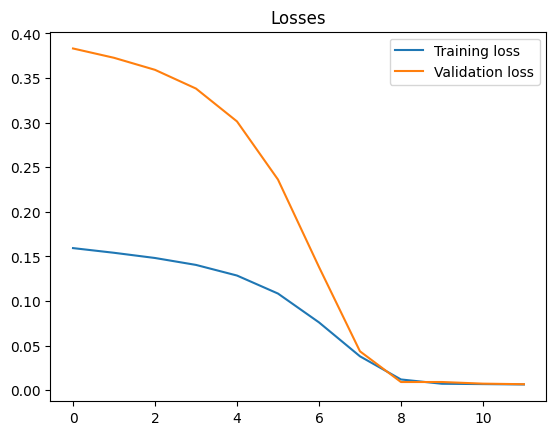

PRED: [204.1533  202.0281  207.25165 198.46538 200.81146 203.96071 204.46347
 213.00085 206.44725 210.47328 221.9584  206.98515]
REAL: [188.80437 192.83313 192.20369 194.78844 190.66109 190.3997  192.2271
 191.29836 187.32166 192.0135  189.2994  191.61847]


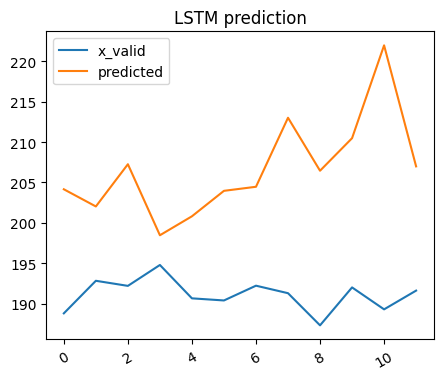

{'mae': 15.544178, 'rmse': 17.022178095623975}


In [ ]:
batch_size = 8
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 96
layer_dim = 3
dropout = 0.1
n_epochs = 12
learning_rate = 0.0001
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = LSTMModel(**model_params)

# loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)
df_result = format_predictions(predictions, values, X_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("LSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

## Grid search on GRU

In [ ]:
config = {
    "learning_rate":  tune.grid_search([1e-4, 1e-3, 1e-2]),
    "batch_size": tune.grid_search([8, 16]),
    "input_dim": tune.grid_search([12, 36]),
    "hidden_dim": tune.grid_search([128, 256, 512]),
    "layer_dim" : tune.grid_search([3, 4, 5]),
    "dropout" : tune.grid_search([0.1, 0.2]),
    "delta": tune.grid_search([1.0, 1.5])
}


In [ ]:
def train_wrapper(config):
  input_dim = config["input_dim"]
  output_dim = 12
  X, y, div = createDataset(df, input_dim, output_dim)
  X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
  train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, config["batch_size"])

  n_epochs = 6
  weight_decay = 1e-6

  model_params = {
      'input_dim': input_dim,
      'output_dim' : output_dim,
      'hidden_dim' : config["hidden_dim"],
      'layer_dim' : config["layer_dim"],
      'dropout_prob' : config["dropout"]
}

  model = GRUModel(**model_params)

  # loss_fn = nn.MSELoss(reduction="mean")
  loss_fn = nn.HuberLoss(reduction='mean', delta=config["delta"])
  # loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=weight_decay)

  opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=config["batch_size"], n_epochs=n_epochs, n_features=input_dim)
  predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

  predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
  values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
  # print("PRED:", predictions)
  # print("REAL:", values)
  df_result = format_predictions(predictions, values, X_test)
  result_metrics = calculate_metrics(df_result)
  tune.report(accuracy=result_metrics["mae"])

In [ ]:
analysis = tune.run(
  train_wrapper,
  config=config,
  resources_per_trial={"cpu": 2, "gpu": 1},
)

2023-04-30 08:46:11,487	WARNING callback.py:142 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(train_wrapper pid=7646) [1/6] Training loss: 0.1262	 Validation loss: 0.3633 [repeated 6x across cluster]


Trial name,accuracy,date,done,experiment_tag,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_wrapper_75408_00000,28.1926,2023-04-30_08-46-17,True,"0_batch_size=8,delta=1.0000,dropout=0.1000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,7646,0.846177,0.846177,0.846177,1682844377,1,75408_00000
train_wrapper_75408_00001,107.83,2023-04-30_08-46-22,True,"1_batch_size=16,delta=1.0000,dropout=0.1000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,7712,0.598157,0.598157,0.598157,1682844382,1,75408_00001
train_wrapper_75408_00002,25.9806,2023-04-30_08-46-28,True,"2_batch_size=8,delta=1.5000,dropout=0.1000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,7777,1.10558,1.10558,1.10558,1682844388,1,75408_00002
train_wrapper_75408_00003,104.916,2023-04-30_08-46-33,True,"3_batch_size=16,delta=1.5000,dropout=0.1000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,7848,0.611264,0.611264,0.611264,1682844393,1,75408_00003
train_wrapper_75408_00004,22.9855,2023-04-30_08-46-38,True,"4_batch_size=8,delta=1.0000,dropout=0.2000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,7914,0.821176,0.821176,0.821176,1682844398,1,75408_00004
train_wrapper_75408_00005,102.089,2023-04-30_08-46-44,True,"5_batch_size=16,delta=1.0000,dropout=0.2000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,7979,0.865776,0.865776,0.865776,1682844404,1,75408_00005
train_wrapper_75408_00006,28.4884,2023-04-30_08-46-51,True,"6_batch_size=8,delta=1.5000,dropout=0.2000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,8054,0.84515,0.84515,0.84515,1682844411,1,75408_00006
train_wrapper_75408_00007,110.123,2023-04-30_08-46-56,True,"7_batch_size=16,delta=1.5000,dropout=0.2000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,8123,0.792774,0.792774,0.792774,1682844416,1,75408_00007
train_wrapper_75408_00008,4.54347,2023-04-30_08-47-03,True,"8_batch_size=8,delta=1.0000,dropout=0.1000,hidden_dim=256,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,8193,0.850245,0.850245,0.850245,1682844423,1,75408_00008
train_wrapper_75408_00009,65.9815,2023-04-30_08-47-08,True,"9_batch_size=16,delta=1.0000,dropout=0.1000,hidden_dim=256,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,8264,0.622849,0.622849,0.622849,1682844428,1,75408_00009


(train_wrapper pid=7712) [6/6] Training loss: 0.0984	 Validation loss: 0.2989 [repeated 11x across cluster]
(train_wrapper pid=7777) [1/6] Training loss: 0.1351	 Validation loss: 0.3820
(train_wrapper pid=7777) [2/6] Training loss: 0.1228	 Validation loss: 0.3504
(train_wrapper pid=7777) [3/6] Training loss: 0.1063	 Validation loss: 0.2989
(train_wrapper pid=7777) [4/6] Training loss: 0.0797	 Validation loss: 0.2111
(train_wrapper pid=7777) [5/6] Training loss: 0.0438	 Validation loss: 0.0964
(train_wrapper pid=7777) [6/6] Training loss: 0.0162	 Validation loss: 0.0206
(train_wrapper pid=7848) [1/6] Training loss: 0.1303	 Validation loss: 0.3863
(train_wrapper pid=7848) [2/6] Training loss: 0.1248	 Validation loss: 0.3733
(train_wrapper pid=7848) [3/6] Training loss: 0.1191	 Validation loss: 0.3582
(train_wrapper pid=7848) [4/6] Training loss: 0.1123	 Validation loss: 0.3392
(train_wrapper pid=7848) [5/6] Training loss: 0.1038	 Validation loss: 0.3143
(train_wrapper pid=7848) [6/6] Tra

2023-04-30 09:29:21,554	INFO tune.py:945 -- Total run time: 2590.11 seconds (2589.81 seconds for the tuning loop).


In [ ]:
best_trial = analysis.get_best_trial("accuracy", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation accuracy (MAE): {}".format(
    best_trial.last_result["accuracy"]))

Best trial config: {'learning_rate': 0.0001, 'batch_size': 8, 'input_dim': 12, 'hidden_dim': 256, 'layer_dim': 4, 'dropout': 0.2, 'delta': 1.0}
Best trial final validation accuracy (MAE): 2.47168231010437


## GRU

[1/6] Training loss: 0.1498	 Validation loss: 0.3609
[2/6] Training loss: 0.1378	 Validation loss: 0.3327
[3/6] Training loss: 0.1187	 Validation loss: 0.2742
[4/6] Training loss: 0.0786	 Validation loss: 0.1431
[5/6] Training loss: 0.0230	 Validation loss: 0.0145
[6/6] Training loss: 0.0103	 Validation loss: 0.0051


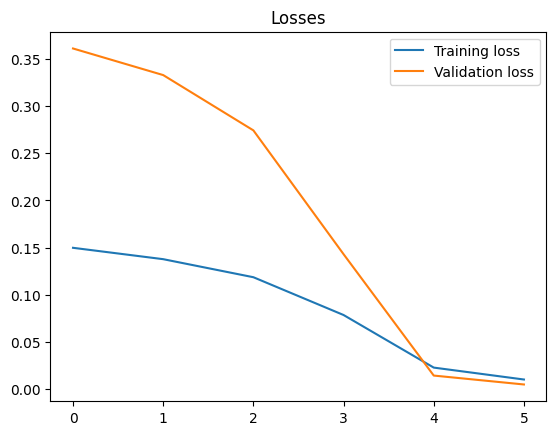

PRED: [213.33511 196.19615 201.29585 191.57124 192.37094 196.00452 199.95993
 215.01479 203.44186 202.46382 207.65742 212.9269 ]
REAL: [188.80437 192.83313 192.20369 194.78844 190.66109 190.3997  192.2271
 191.29836 187.32166 192.0135  189.2994  191.61847]


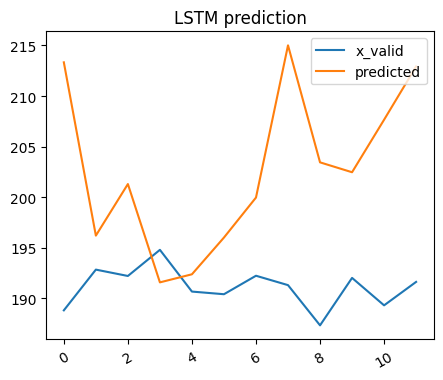

{'mae': 12.100337, 'rmse': 14.49949750358423}


In [ ]:
batch_size = 8
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 128
layer_dim = 4
dropout = 0.1
n_epochs = 6
learning_rate = 0.0001
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = GRUModel(**model_params)

# loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = nn.HuberLoss(reduction='mean', delta=1.5)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)
df_result = format_predictions(predictions, values, X_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("LSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

## Grid search on RNN

In [ ]:
config = {
    "learning_rate":  tune.grid_search([1e-4, 1e-3, 1e-2]),
    "batch_size": tune.grid_search([8, 16]),
    "input_dim": tune.grid_search([12, 36]),
    "hidden_dim": tune.grid_search([128, 256, 512]),
    "layer_dim" : tune.grid_search([3, 4, 5]),
    "dropout" : tune.grid_search([0.1, 0.2]),
    "delta": tune.grid_search([1.0, 1.5])
}


In [ ]:
def train_wrapper(config):
  input_dim = config["input_dim"]
  output_dim = 12
  X, y, div = createDataset(df, input_dim, output_dim)
  X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
  train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, config["batch_size"])

  n_epochs = 12
  weight_decay = 1e-6

  model_params = {
      'input_dim': input_dim,
      'output_dim' : output_dim,
      'hidden_dim' : config["hidden_dim"],
      'layer_dim' : config["layer_dim"],
      'dropout_prob' : config["dropout"]
}

  model = RNNModel(**model_params)

  # loss_fn = nn.MSELoss(reduction="mean")
  loss_fn = nn.HuberLoss(reduction='mean', delta=config["delta"])
  # loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=weight_decay)

  opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=config["batch_size"], n_epochs=n_epochs, n_features=input_dim)
  predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

  predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
  values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
  # print("PRED:", predictions)
  # print("REAL:", values)
  df_result = format_predictions(predictions, values, X_test)
  result_metrics = calculate_metrics(df_result)
  tune.report(accuracy=result_metrics["mae"])

In [ ]:
analysis = tune.run(
  train_wrapper,
  config=config,
  resources_per_trial={"cpu": 2, "gpu": 1},
)

2023-04-30 09:36:43,474	WARNING callback.py:142 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(train_wrapper pid=40010) [2/12] Training loss: 0.0628	 Validation loss: 0.1620 [repeated 7x across cluster]


Trial name,accuracy,date,done,experiment_tag,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_wrapper_84751_00000,6.54688,2023-04-30_09-36-48,True,"0_batch_size=8,delta=1.0000,dropout=0.1000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,40010,1.26168,1.26168,1.26168,1682847408,1,84751_00000
train_wrapper_84751_00001,16.3596,2023-04-30_09-36-56,True,"1_batch_size=16,delta=1.0000,dropout=0.1000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,40084,0.830212,0.830212,0.830212,1682847416,1,84751_00001
train_wrapper_84751_00002,5.91027,2023-04-30_09-37-01,True,"2_batch_size=8,delta=1.5000,dropout=0.1000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,40155,1.22054,1.22054,1.22054,1682847421,1,84751_00002
train_wrapper_84751_00003,14.0488,2023-04-30_09-37-09,True,"3_batch_size=16,delta=1.5000,dropout=0.1000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,40230,1.25607,1.25607,1.25607,1682847429,1,84751_00003
train_wrapper_84751_00004,6.70976,2023-04-30_09-37-14,True,"4_batch_size=8,delta=1.0000,dropout=0.2000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,40306,1.23283,1.23283,1.23283,1682847434,1,84751_00004
train_wrapper_84751_00005,18.1711,2023-04-30_09-37-20,True,"5_batch_size=16,delta=1.0000,dropout=0.2000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,40376,1.19085,1.19085,1.19085,1682847440,1,84751_00005
train_wrapper_84751_00006,5.31369,2023-04-30_09-37-27,True,"6_batch_size=8,delta=1.5000,dropout=0.2000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,40450,1.25043,1.25043,1.25043,1682847447,1,84751_00006
train_wrapper_84751_00007,19.1829,2023-04-30_09-37-32,True,"7_batch_size=16,delta=1.5000,dropout=0.2000,hidden_dim=128,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,40518,0.8103,0.8103,0.8103,1682847452,1,84751_00007
train_wrapper_84751_00008,10.8666,2023-04-30_09-37-39,True,"8_batch_size=8,delta=1.0000,dropout=0.1000,hidden_dim=256,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,40584,1.68195,1.68195,1.68195,1682847459,1,84751_00008
train_wrapper_84751_00009,3.68334,2023-04-30_09-37-44,True,"9_batch_size=16,delta=1.0000,dropout=0.1000,hidden_dim=256,input_dim=12,layer_dim=3,learning_rate=0.0001",93ac9f945895,1,172.28.0.12,40661,0.841925,0.841925,0.841925,1682847464,1,84751_00009


(train_wrapper pid=40084) [4/12] Training loss: 0.0636	 Validation loss: 0.1941 [repeated 12x across cluster]
(train_wrapper pid=40155) [1/12] Training loss: 0.0996	 Validation loss: 0.2700 [repeated 7x across cluster]
(train_wrapper pid=40230) [2/12] Training loss: 0.0931	 Validation loss: 0.2693 [repeated 11x across cluster]
(train_wrapper pid=40306) [1/12] Training loss: 0.1017	 Validation loss: 0.2681 [repeated 9x across cluster]
(train_wrapper pid=40376) [2/12] Training loss: 0.1062	 Validation loss: 0.3103 [repeated 11x across cluster]
(train_wrapper pid=40450) [2/12] Training loss: 0.0633	 Validation loss: 0.1738 [repeated 10x across cluster]
(train_wrapper pid=40518) [2/12] Training loss: 0.1022	 Validation loss: 0.3007 [repeated 10x across cluster]
(train_wrapper pid=40584) [1/12] Training loss: 0.0858	 Validation loss: 0.2001 [repeated 9x across cluster]
(train_wrapper pid=40661) [2/12] Training loss: 0.0812	 Validation loss: 0.2295 [repeated 11x across cluster]
(train_wrappe

In [ ]:
best_trial = analysis.get_best_trial("accuracy", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation accuracy (MAE): {}".format(
    best_trial.last_result["accuracy"]))

NameError: ignored

## RNN

[1/8] Training loss: 0.1425	 Validation loss: 0.2965
[2/8] Training loss: 0.0953	 Validation loss: 0.1910
[3/8] Training loss: 0.0538	 Validation loss: 0.0955
[4/8] Training loss: 0.0244	 Validation loss: 0.0357
[5/8] Training loss: 0.0140	 Validation loss: 0.0126
[6/8] Training loss: 0.0119	 Validation loss: 0.0056
[7/8] Training loss: 0.0109	 Validation loss: 0.0036
[8/8] Training loss: 0.0100	 Validation loss: 0.0030


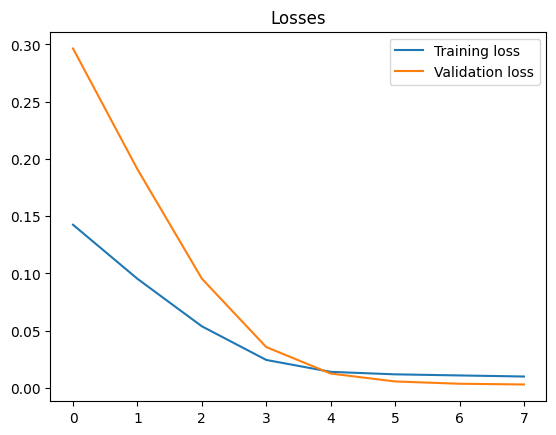

PRED: [183.33636 189.20686 187.2084  193.28745 185.1298  189.13297 201.66774
 189.83588 196.28609 203.1025  194.44443 198.77574]
REAL: [188.80437 192.83313 192.20369 194.78844 190.66109 190.3997  192.2271
 191.29836 187.32166 192.0135  189.2994  191.61847]


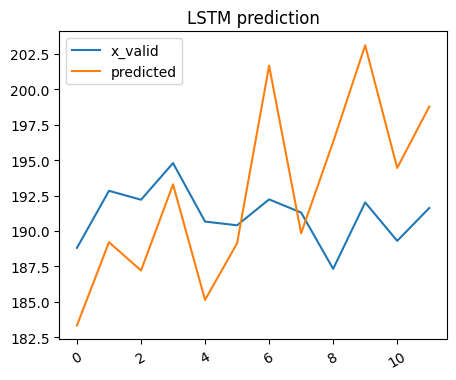

{'mae': 5.470618, 'rmse': 6.289830662035352}


In [ ]:
batch_size = 8
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 96
layer_dim = 3
dropout = 0.1
n_epochs = 8
learning_rate = 0.0001
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = RNNModel(**model_params)

# loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.CrossEntropyLoss(reduction="mean")
loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)
df_result = format_predictions(predictions, values, X_test)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("LSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Tuning Residual LSTM

Модель сходится намного быстрее, 8 батчей и 4 эпох уже достаточно

## Grid search

In [ ]:
config = {
    "learning_rate":  tune.grid_search([6e-4, 6e-3, 1e-2]),
    "batch_size": tune.grid_search([8]),
    "input_dim": tune.grid_search([12, 24, 36]),
    "hidden_dim": tune.grid_search([128, 164, 256]),
    "layers_count" : tune.grid_search([4, 5]),
    "layer_dim" : tune.grid_search([1, 2]),
    "dropout" : tune.grid_search([0.1, 0.2]),
    "delta": tune.grid_search([1.0])
}


In [ ]:
def train_wrapper(config):
  input_dim = config["input_dim"]
  output_dim = 12
  X, y, div = createDataset(df, input_dim, output_dim)
  X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
  train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, config["batch_size"])

  n_epochs = 6
  weight_decay = 1e-6

  model_params = {
      'input_dim': input_dim,
      'output_dim' : output_dim,
      'hidden_dim' : config["hidden_dim"],
      'layer_dim' : config["layer_dim"],
      "layers_count" : config["layers_count"], 
      'dropout_prob' : config["dropout"]
  }
  model = ResLSTMModel(**model_params)

  loss_fn = nn.MSELoss(reduction="mean")
  # loss_fn = nn.HuberLoss(reduction='mean', delta=config["delta"])
  # loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=weight_decay)

  opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=config["batch_size"], n_epochs=n_epochs, n_features=input_dim)
  predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)

  predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
  values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
  # print("PRED:", predictions)
  # print("REAL:", values)
  df_result = format_predictions(predictions, values, X_test)
  result_metrics = calculate_metrics(df_result)
  tune.report(accuracy=result_metrics["mae"])

In [ ]:
analysis = tune.run(
  train_wrapper,
  config=config,
  resources_per_trial={"cpu": 2, "gpu": 1},
)
best_trial = analysis.get_best_trial("accuracy", "min", "last")

2023-04-29 19:40:52,458	WARNING callback.py:142 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(train_wrapper pid=94513) Creating Residual LSTM model 12 128 1 4 12 0.1
(train_wrapper pid=94331)  191.29836 187.32166 192.0135  189.2994  191.61847] [repeated 2x across cluster]
(train_wrapper pid=94331) [6/6] Training loss: 0.0300	 Validation loss: 0.0167 [repeated 6x across cluster]
(train_wrapper pid=94513) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=94513) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=94513) Creating Residual LSTM 128 128 1 0.1


(train_wrapper pid=94513) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=94513)   warnings.warn("dropout option adds dropout after all but last "


Trial name,accuracy,date,done,experiment_tag,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
train_wrapper_c01f6_00000,3.49414,2023-04-29_19-40-59,True,"0_batch_size=8,delta=1.0000,dropout=0.1000,hidden_dim=128,input_dim=12,layer_dim=1,layers_count=4,learning_rate=0.0006",cbb931020cc0,1,172.28.0.12,94513,1.09721,1.09721,1.09721,1682797259,1,c01f6_00000
train_wrapper_c01f6_00001,4.70978,2023-04-29_19-41-07,True,"1_batch_size=8,delta=1.0000,dropout=0.2000,hidden_dim=128,input_dim=12,layer_dim=1,layers_count=4,learning_rate=0.0006",cbb931020cc0,1,172.28.0.12,94597,1.20763,1.20763,1.20763,1682797267,1,c01f6_00001
train_wrapper_c01f6_00002,4.38495,2023-04-29_19-41-15,True,"2_batch_size=8,delta=1.0000,dropout=0.1000,hidden_dim=164,input_dim=12,layer_dim=1,layers_count=4,learning_rate=0.0006",cbb931020cc0,1,172.28.0.12,94683,1.10212,1.10212,1.10212,1682797275,1,c01f6_00002
train_wrapper_c01f6_00003,4.30118,2023-04-29_19-41-21,True,"3_batch_size=8,delta=1.0000,dropout=0.2000,hidden_dim=164,input_dim=12,layer_dim=1,layers_count=4,learning_rate=0.0006",cbb931020cc0,1,172.28.0.12,94766,1.09223,1.09223,1.09223,1682797281,1,c01f6_00003
train_wrapper_c01f6_00004,11.8173,2023-04-29_19-41-29,True,"4_batch_size=8,delta=1.0000,dropout=0.1000,hidden_dim=256,input_dim=12,layer_dim=1,layers_count=4,learning_rate=0.0006",cbb931020cc0,1,172.28.0.12,94842,1.50607,1.50607,1.50607,1682797289,1,c01f6_00004
train_wrapper_c01f6_00005,12.323,2023-04-29_19-41-35,True,"5_batch_size=8,delta=1.0000,dropout=0.2000,hidden_dim=256,input_dim=12,layer_dim=1,layers_count=4,learning_rate=0.0006",cbb931020cc0,1,172.28.0.12,94921,1.16019,1.16019,1.16019,1682797295,1,c01f6_00005
train_wrapper_c01f6_00006,13.5237,2023-04-29_19-41-45,True,"6_batch_size=8,delta=1.0000,dropout=0.1000,hidden_dim=128,input_dim=24,layer_dim=1,layers_count=4,learning_rate=0.0006",cbb931020cc0,1,172.28.0.12,94995,1.06275,1.06275,1.06275,1682797305,1,c01f6_00006
train_wrapper_c01f6_00007,10.4373,2023-04-29_19-41-52,True,"7_batch_size=8,delta=1.0000,dropout=0.2000,hidden_dim=128,input_dim=24,layer_dim=1,layers_count=4,learning_rate=0.0006",cbb931020cc0,1,172.28.0.12,95089,1.38665,1.38665,1.38665,1682797312,1,c01f6_00007
train_wrapper_c01f6_00008,13.9404,2023-04-29_19-42-03,True,"8_batch_size=8,delta=1.0000,dropout=0.1000,hidden_dim=164,input_dim=24,layer_dim=1,layers_count=4,learning_rate=0.0006",cbb931020cc0,1,172.28.0.12,95169,2.20996,2.20996,2.20996,1682797323,1,c01f6_00008
train_wrapper_c01f6_00009,14.2241,2023-04-29_19-42-17,True,"9_batch_size=8,delta=1.0000,dropout=0.2000,hidden_dim=164,input_dim=24,layer_dim=1,layers_count=4,learning_rate=0.0006",cbb931020cc0,1,172.28.0.12,95265,7.17338,7.17338,7.17338,1682797337,1,c01f6_00009


(train_wrapper pid=94597)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=94597)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=94597) Creating Residual LSTM model 12 128 1 4 12 0.2
(train_wrapper pid=94513) [6/6] Training loss: 0.0212	 Validation loss: 0.0024 [repeated 6x across cluster]
(train_wrapper pid=94597) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=94597) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=94597) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=94683) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=94683)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=94683) Creating Residual LSTM model 12 164 1 4 12 0.1
(train_wrapper pid=94597) [6/6] Training loss: 0.0143	 Validation loss: 0.0046 [repeated 6x across cluster]
(train_wrapper pid=94683) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=94683) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=94683) Creating Residual LSTM 164 164 1 0.1


(train_wrapper pid=94766)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=94766)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=94766) Creating Residual LSTM model 12 164 1 4 12 0.2
(train_wrapper pid=94683) [6/6] Training loss: 0.0157	 Validation loss: 0.0050 [repeated 6x across cluster]
(train_wrapper pid=94766) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=94766) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=94766) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=94842) Creating Residual LSTM model 12 256 1 4 12 0.1
(train_wrapper pid=94766) [6/6] Training loss: 0.0144	 Validation loss: 0.0048 [repeated 6x across cluster]


(train_wrapper pid=94842) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=94842)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=94842) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=94842) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=94842) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=94921)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=94921)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=94921) Creating Residual LSTM model 12 256 1 4 12 0.2
(train_wrapper pid=94842) [6/6] Training loss: 0.0085	 Validation loss: 0.0160 [repeated 6x across cluster]
(train_wrapper pid=94921) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=94921) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=94921) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=94995) Creating Residual LSTM model 24 128 1 4 12 0.1
(train_wrapper pid=94921) [6/6] Training loss: 0.0086	 Validation loss: 0.0163 [repeated 6x across cluster]
(train_wrapper pid=94995) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=94995) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=94995) Creating Residual LSTM 128 128 1 0.1


(train_wrapper pid=94995) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=94995)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=95089)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=95089)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=95089) Creating Residual LSTM model 24 128 1 4 12 0.2
(train_wrapper pid=94995) [6/6] Training loss: 0.0127	 Validation loss: 0.0170 [repeated 6x across cluster]
(train_wrapper pid=95089) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=95089) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=95089) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=95169) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=95169)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=95169) Creating Residual LSTM model 24 164 1 4 12 0.1
(train_wrapper pid=95089) [6/6] Training loss: 0.0151	 Validation loss: 0.0131 [repeated 6x across cluster]
(train_wrapper pid=95169) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=95169) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=95169) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=95265) Creating Residual LSTM model 24 164 1 4 12 0.2
(train_wrapper pid=95169) [6/6] Training loss: 0.0125	 Validation loss: 0.0183 [repeated 6x across cluster]


(train_wrapper pid=95265)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=95265)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=95265) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=95265) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=95265) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=95265) [4/6] Training loss: 0.0228	 Validation loss: 0.0066 [repeated 4x across cluster]
(train_wrapper pid=95374) Creating Residual LSTM model 24 256 1 4 12 0.1
(train_wrapper pid=95265) [6/6] Training loss: 0.0100	 Validation loss: 0.0199 [repeated 2x across cluster]


(train_wrapper pid=95374) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=95374)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=95374) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=95374) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=95374) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=95462)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=95462)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=95462) Creating Residual LSTM model 24 256 1 4 12 0.2
(train_wrapper pid=95374) [6/6] Training loss: 0.0111	 Validation loss: 0.0242 [repeated 6x across cluster]
(train_wrapper pid=95462) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=95462) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=95462) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=95545) Creating Residual LSTM model 36 128 1 4 12 0.1
(train_wrapper pid=95462) [6/6] Training loss: 0.0103	 Validation loss: 0.0228 [repeated 6x across cluster]


(train_wrapper pid=95545) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=95545)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=95545) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=95545) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=95545) Creating Residual LSTM 128 128 1 0.1


(train_wrapper pid=95622)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=95622)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=95622) Creating Residual LSTM model 36 128 1 4 12 0.2
(train_wrapper pid=95545) [6/6] Training loss: 0.0167	 Validation loss: 0.0188 [repeated 6x across cluster]
(train_wrapper pid=95622) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=95622) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=95622) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=95705) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=95705)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=95705) Creating Residual LSTM model 36 164 1 4 12 0.1
(train_wrapper pid=95622) [6/6] Training loss: 0.0136	 Validation loss: 0.0207 [repeated 6x across cluster]
(train_wrapper pid=95705) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=95705) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=95705) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=95780) Creating Residual LSTM model 36 164 1 4 12 0.2
(train_wrapper pid=95705) [6/6] Training loss: 0.0131	 Validation loss: 0.0249 [repeated 6x across cluster]


(train_wrapper pid=95780)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=95780)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=95780) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=95780) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=95780) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=95858) Creating Residual LSTM model 36 256 1 4 12 0.1
(train_wrapper pid=95780) [6/6] Training loss: 0.0168	 Validation loss: 0.0350 [repeated 6x across cluster]
(train_wrapper pid=95858) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=95858) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=95858) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=95858) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=95858)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=95935) Creating Residual LSTM model 36 256 1 4 12 0.2
(train_wrapper pid=95858) [6/6] Training loss: 0.0134	 Validation loss: 0.0293 [repeated 6x across cluster]
(train_wrapper pid=95935) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=95935) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=95935) Creating Residual LSTM 256 256 1 0.2


(train_wrapper pid=95935)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=95935)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=96010) Creating Residual LSTM model 12 128 2 4 12 0.1
(train_wrapper pid=95935) [6/6] Training loss: 0.0136	 Validation loss: 0.0282 [repeated 6x across cluster]
(train_wrapper pid=96010) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=96010) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=96010) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=96091) Creating Residual LSTM model 12 128 2 4 12 0.2
(train_wrapper pid=96010) [6/6] Training loss: 0.1028	 Validation loss: 0.1813 [repeated 6x across cluster]
(train_wrapper pid=96091) Creating Residual LSTM 128 128 2 0.2
(train_wrapper pid=96091) Creating Residual LSTM 128 128 2 0.2
(train_wrapper pid=96091) Creating Residual LSTM 128 128 2 0.2
(train_wrapper pid=96166) Creating Residual LSTM model 12 164 2 4 12 0.1
(train_wrapper pid=96091) [6/6] Training loss: 0.1039	 Validation loss: 0.1963 [repeated 6x across cluster]
(train_wrapper pid=96166) Creating Residual LSTM 164 164 2 0.1
(train_wrapper p

(train_wrapper pid=97423) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=97423)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=97423) Creating Residual LSTM model 12 128 1 5 12 0.1
(train_wrapper pid=97344) [6/6] Training loss: 0.1072	 Validation loss: 0.0784 [repeated 6x across cluster]
(train_wrapper pid=97423) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=97423) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=97423) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=97423) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=97497) Creating Residual LSTM model 12 128 1 5 12 0.2
(train_wrapper pid=97423) [6/6] Training loss: 0.0194	 Validation loss: 0.0035 [repeated 6x across cluster]
(train_wrapper pid=97497) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=97497) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=97497) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=97497) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=97497)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=97497)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=97573) Creating Residual LSTM model 12 164 1 5 12 0.1
(train_wrapper pid=97497) [6/6] Training loss: 0.0136	 Validation loss: 0.0052 [repeated 6x across cluster]
(train_wrapper pid=97573) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=97573) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=97573) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=97573) Creating Residual LSTM 164 164 1 0.1


(train_wrapper pid=97573) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=97573)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=97663)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=97663)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=97663) Creating Residual LSTM model 12 164 1 5 12 0.2
(train_wrapper pid=97573) [6/6] Training loss: 0.0095	 Validation loss: 0.0098 [repeated 6x across cluster]
(train_wrapper pid=97663) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=97663) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=97663) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=97663) Creating Residual LSTM 164 164 1 0.2


(train_wrapper pid=97737) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=97737)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=97737) Creating Residual LSTM model 12 256 1 5 12 0.1
(train_wrapper pid=97663) [6/6] Training loss: 0.0125	 Validation loss: 0.0075 [repeated 6x across cluster]
(train_wrapper pid=97737) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=97737) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=97737) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=97737) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=97825)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=97825)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=97825) Creating Residual LSTM model 12 256 1 5 12 0.2
(train_wrapper pid=97737) [6/6] Training loss: 0.0075	 Validation loss: 0.0157 [repeated 6x across cluster]
(train_wrapper pid=97825) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=97825) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=97825) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=97825) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=97902) Creating Residual LSTM model 24 128 1 5 12 0.1
(train_wrapper pid=97825) [6/6] Training loss: 0.0072	 Validation loss: 0.0139 [repeated 6x across cluster]
(train_wrapper pid=97902) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=97902) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=97902) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=97902) Creating Residual LSTM 128 128 1 0.1


(train_wrapper pid=97902) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=97902)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=97980) Creating Residual LSTM model 24 128 1 5 12 0.2
(train_wrapper pid=97902) [6/6] Training loss: 0.0185	 Validation loss: 0.0101 [repeated 6x across cluster]


(train_wrapper pid=97980)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=97980)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=97980) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=97980) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=97980) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=97980) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=98056) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=98056)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=98056) Creating Residual LSTM model 24 164 1 5 12 0.1
(train_wrapper pid=97980) [6/6] Training loss: 0.0179	 Validation loss: 0.0087 [repeated 6x across cluster]
(train_wrapper pid=98056) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=98056) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=98056) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=98056) Creating Residual LSTM 164 164 1 0.1


(train_wrapper pid=98138)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=98138)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=98138) Creating Residual LSTM model 24 164 1 5 12 0.2
(train_wrapper pid=98056) [6/6] Training loss: 0.0134	 Validation loss: 0.0203 [repeated 6x across cluster]
(train_wrapper pid=98138) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=98138) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=98138) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=98138) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=98214) Creating Residual LSTM model 24 256 1 5 12 0.1
(train_wrapper pid=98138) [6/6] Training loss: 0.0125	 Validation loss: 0.0226 [repeated 6x across cluster]


(train_wrapper pid=98214) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=98214)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=98214) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=98214) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=98214) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=98214) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=98294)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=98294)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=98294) Creating Residual LSTM model 24 256 1 5 12 0.2
(train_wrapper pid=98214) [6/6] Training loss: 0.0117	 Validation loss: 0.0260 [repeated 6x across cluster]
(train_wrapper pid=98294) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=98294) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=98294) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=98294) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=98368) Creating Residual LSTM model 36 128 1 5 12 0.1
(train_wrapper pid=98294) [6/6] Training loss: 0.0104	 Validation loss: 0.0233 [repeated 6x across cluster]


(train_wrapper pid=98368) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=98368)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=98368) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=98368) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=98368) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=98368) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=98444) Creating Residual LSTM model 36 128 1 5 12 0.2
(train_wrapper pid=98368) [6/6] Training loss: 0.0190	 Validation loss: 0.0176 [repeated 6x across cluster]


(train_wrapper pid=98444)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=98444)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=98444) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=98444) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=98444) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=98444) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=98521) Creating Residual LSTM model 36 164 1 5 12 0.1
(train_wrapper pid=98444) [6/6] Training loss: 0.0182	 Validation loss: 0.0151 [repeated 6x across cluster]


(train_wrapper pid=98521) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=98521)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=98521) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=98521) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=98521) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=98521) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=98594) Creating Residual LSTM model 36 164 1 5 12 0.2
(train_wrapper pid=98521) [6/6] Training loss: 0.0124	 Validation loss: 0.0246 [repeated 6x across cluster]


(train_wrapper pid=98594)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=98594)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=98594) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=98594) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=98594) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=98594) Creating Residual LSTM 164 164 1 0.2


(train_wrapper pid=98679) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=98679)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=98679) Creating Residual LSTM model 36 256 1 5 12 0.1
(train_wrapper pid=98594) [6/6] Training loss: 0.0137	 Validation loss: 0.0267 [repeated 6x across cluster]
(train_wrapper pid=98679) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=98679) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=98679) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=98679) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=98761) Creating Residual LSTM model 36 256 1 5 12 0.2
(train_wrapper pid=98679) [6/6] Training loss: 0.0122	 Validation loss: 0.0265 [repeated 6x across cluster]


(train_wrapper pid=98761)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=98761)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=98761) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=98761) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=98761) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=98761) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=98861) Creating Residual LSTM model 12 128 2 5 12 0.1
(train_wrapper pid=98761) [6/6] Training loss: 0.0136	 Validation loss: 0.0294 [repeated 6x across cluster]
(train_wrapper pid=98861) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=98861) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=98861) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=98861) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=98933) Creating Residual LSTM model 12 128 2 5 12 0.2
(train_wrapper pid=98861) [6/6] Training loss: 0.1080	 Validation loss: 0.2059 [repeated 6x across cluster]
(train_wrapper pid=98933) Creating Residual LSTM 128 128 2 0.2
(train_wrapper pid=98933) Creating Residual LSTM 128 128 2 0.2
(train_w

(train_wrapper pid=100277) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=100277)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=100277) Creating Residual LSTM model 12 128 1 4 12 0.1
(train_wrapper pid=100202) [6/6] Training loss: 0.1131	 Validation loss: 0.1040 [repeated 6x across cluster]
(train_wrapper pid=100277) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=100277) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=100277) Creating Residual LSTM 128 128 1 0.1


(train_wrapper pid=100362)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=100362)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=100362) Creating Residual LSTM model 12 128 1 4 12 0.2
(train_wrapper pid=100277) [6/6] Training loss: 0.0070	 Validation loss: 0.0073 [repeated 6x across cluster]
(train_wrapper pid=100362) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=100362) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=100362) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=100436) Creating Residual LSTM model 12 164 1 4 12 0.1
(train_wrapper pid=100362) [6/6] Training loss: 0.0087	 Validation loss: 0.0101 [repeated 6x across cluster]


(train_wrapper pid=100436) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=100436)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=100436) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=100436) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=100436) Creating Residual LSTM 164 164 1 0.1


(train_wrapper pid=100517)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=100517)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=100517) Creating Residual LSTM model 12 164 1 4 12 0.2
(train_wrapper pid=100436) [6/6] Training loss: 0.0088	 Validation loss: 0.0035 [repeated 6x across cluster]
(train_wrapper pid=100517) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=100517) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=100517) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=100600) Creating Residual LSTM model 12 256 1 4 12 0.1
(train_wrapper pid=100517) [6/6] Training loss: 0.0106	 Validation loss: 0.0037 [repeated 6x across cluster]


(train_wrapper pid=100600) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=100600)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=100600) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=100600) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=100600) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=100677) Creating Residual LSTM model 12 256 1 4 12 0.2
(train_wrapper pid=100600) [6/6] Training loss: 0.0226	 Validation loss: 0.0443 [repeated 6x across cluster]


(train_wrapper pid=100677)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=100677)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=100677) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=100677) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=100677) Creating Residual LSTM 256 256 1 0.2


(train_wrapper pid=100770) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=100770)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=100770) Creating Residual LSTM model 24 128 1 4 12 0.1
(train_wrapper pid=100677) [6/6] Training loss: 0.0196	 Validation loss: 0.0417 [repeated 6x across cluster]
(train_wrapper pid=100770) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=100770) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=100770) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=100846) Creating Residual LSTM model 24 128 1 4 12 0.2
(train_wrapper pid=100770) [6/6] Training loss: 0.0156	 Validation loss: 0.0073 [repeated 6x across cluster]


(train_wrapper pid=100846)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=100846)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=100846) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=100846) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=100846) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=100919) Creating Residual LSTM model 24 164 1 4 12 0.1
(train_wrapper pid=100846) [6/6] Training loss: 0.0181	 Validation loss: 0.0056 [repeated 6x across cluster]
(train_wrapper pid=100919) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=100919) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=100919) Creating Residual LSTM 164 164 1 0.1


(train_wrapper pid=100919) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=100919)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=100997)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=100997)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=100997) Creating Residual LSTM model 24 164 1 4 12 0.2
(train_wrapper pid=100919) [6/6] Training loss: 0.0145	 Validation loss: 0.0081 [repeated 6x across cluster]
(train_wrapper pid=100997) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=100997) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=100997) Creating Residual LSTM 164 164 1 0.2


(train_wrapper pid=101081) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=101081)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=101081) Creating Residual LSTM model 24 256 1 4 12 0.1
(train_wrapper pid=100997) [6/6] Training loss: 0.0093	 Validation loss: 0.0066 [repeated 6x across cluster]
(train_wrapper pid=101081) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=101081) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=101081) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=101154) Creating Residual LSTM model 24 256 1 4 12 0.2
(train_wrapper pid=101081) [6/6] Training loss: 0.0231	 Validation loss: 0.0105 [repeated 6x across cluster]


(train_wrapper pid=101154)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=101154)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=101154) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=101154) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=101154) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=101238) Creating Residual LSTM model 36 128 1 4 12 0.1
(train_wrapper pid=101154) [6/6] Training loss: 0.0164	 Validation loss: 0.0106 [repeated 6x across cluster]


(train_wrapper pid=101238) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=101238)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=101238) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=101238) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=101238) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=101313) Creating Residual LSTM model 36 128 1 4 12 0.2
(train_wrapper pid=101238) [6/6] Training loss: 0.0169	 Validation loss: 0.0037 [repeated 6x across cluster]


(train_wrapper pid=101313)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=101313)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=101313) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=101313) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=101313) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=101392) Creating Residual LSTM model 36 164 1 4 12 0.1
(train_wrapper pid=101313) [6/6] Training loss: 0.0218	 Validation loss: 0.0058 [repeated 6x across cluster]
(train_wrapper pid=101392) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=101392) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=101392) Creating Residual LSTM 164 164 1 0.1


(train_wrapper pid=101392) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=101392)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=101474)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=101474)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=101474) Creating Residual LSTM model 36 164 1 4 12 0.2
(train_wrapper pid=101392) [6/6] Training loss: 0.0200	 Validation loss: 0.0096 [repeated 6x across cluster]
(train_wrapper pid=101474) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=101474) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=101474) Creating Residual LSTM 164 164 1 0.2


(train_wrapper pid=101545) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=101545)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=101545) Creating Residual LSTM model 36 256 1 4 12 0.1
(train_wrapper pid=101474) [6/6] Training loss: 0.0227	 Validation loss: 0.0346 [repeated 6x across cluster]
(train_wrapper pid=101545) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=101545) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=101545) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=101622)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=101622)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=101622) Creating Residual LSTM model 36 256 1 4 12 0.2
(train_wrapper pid=101545) [6/6] Training loss: 0.0273	 Validation loss: 0.0462 [repeated 6x across cluster]
(train_wrapper pid=101622) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=101622) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=101622) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=101700) Creating Residual LSTM model 12 128 2 4 12 0.1
(train_wrapper pid=101622) [6/6] Training loss: 0.0259	 Validation loss: 0.0356 [repeated 6x across cluster]
(train_wrapper pid=101700) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=101700) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=101700) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=101782) Creating Residual LSTM model 12 128 2 4 12 0.2
(train_wrapper pid=101700) [6/6] Training loss: 0.0990	 Validation loss: 0.2134 [repeated 6x across cluster]
(train_wrapper pid=101782) Creating Residual LSTM 128 128 2 0.2
(tr

(train_wrapper pid=103109) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=103109)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103109) Creating Residual LSTM model 12 128 1 5 12 0.1
(train_wrapper pid=103034) [6/6] Training loss: 0.1506	 Validation loss: 0.1915 [repeated 6x across cluster]
(train_wrapper pid=103109) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=103109) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=103109) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=103109) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=103194) Creating Residual LSTM model 12 128 1 5 12 0.2
(train_wrapper pid=103109) [6/6] Training loss: 0.0096	 Validation loss: 0.0104 [repeated 6x across cluster]
(train_wrapper pid=103194) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=103194) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=103194) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=103194) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=103194)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=103194)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=103270) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=103270)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103270) Creating Residual LSTM model 12 164 1 5 12 0.1
(train_wrapper pid=103194) [6/6] Training loss: 0.0081	 Validation loss: 0.0066 [repeated 6x across cluster]
(train_wrapper pid=103270) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=103270) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=103270) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=103270) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=103348) Creating Residual LSTM model 12 164 1 5 12 0.2
(train_wrapper pid=103270) [6/6] Training loss: 0.0122	 Validation loss: 0.0035 [repeated 6x across cluster]
(train_wrapper pid=103348) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=103348) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=103348) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=103348) Creating Residual LSTM 164 164 1 0.2


(train_wrapper pid=103348)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=103348)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103425) Creating Residual LSTM model 12 256 1 5 12 0.1
(train_wrapper pid=103348) [6/6] Training loss: 0.0087	 Validation loss: 0.0064 [repeated 6x across cluster]


(train_wrapper pid=103425) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=103425)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103425) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=103425) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=103425) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=103425) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=103499)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=103499)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103499) Creating Residual LSTM model 12 256 1 5 12 0.2
(train_wrapper pid=103425) [6/6] Training loss: 0.0249	 Validation loss: 0.0156 [repeated 6x across cluster]
(train_wrapper pid=103499) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=103499) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=103499) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=103499) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=103575) Creating Residual LSTM model 24 128 1 5 12 0.1
(train_wrapper pid=103499) [6/6] Training loss: 0.0313	 Validation loss: 0.0025 [repeated 6x across cluster]
(train_wrapper pid=103575) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=103575) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=103575) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=103575) Creating Residual LSTM 128 128 1 0.1


(train_wrapper pid=103575) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=103575)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103650) Creating Residual LSTM model 24 128 1 5 12 0.2
(train_wrapper pid=103575) [6/6] Training loss: 0.0143	 Validation loss: 0.0137 [repeated 6x across cluster]
(train_wrapper pid=103650) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=103650) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=103650)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=103650)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103650) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=103650) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=103733) Creating Residual LSTM model 24 164 1 5 12 0.1
(train_wrapper pid=103650) [6/6] Training loss: 0.0208	 Validation loss: 0.0034 [repeated 6x across cluster]


(train_wrapper pid=103733) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=103733)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103733) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=103733) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=103733) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=103733) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=103810) Creating Residual LSTM model 24 164 1 5 12 0.2
(train_wrapper pid=103733) [6/6] Training loss: 0.0156	 Validation loss: 0.0140 [repeated 6x across cluster]


(train_wrapper pid=103810)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=103810)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103810) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=103810) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=103810) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=103810) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=103890) Creating Residual LSTM model 24 256 1 5 12 0.1
(train_wrapper pid=103810) [6/6] Training loss: 0.0132	 Validation loss: 0.0124 [repeated 6x across cluster]


(train_wrapper pid=103890) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=103890)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103890) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=103890) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=103890) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=103890) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=103960)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=103960)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=103960) Creating Residual LSTM model 24 256 1 5 12 0.2
(train_wrapper pid=103890) [6/6] Training loss: 0.0317	 Validation loss: 0.0031 [repeated 6x across cluster]
(train_wrapper pid=103960) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=103960) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=103960) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=103960) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=104035) Creating Residual LSTM model 36 128 1 5 12 0.1
(train_wrapper pid=103960) [6/6] Training loss: 0.0107	 Validation loss: 0.0031 [repeated 6x across cluster]
(train_wrapper pid=104035) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=104035) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=104035) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=104035) Creating Residual LSTM 128 128 1 0.1


(train_wrapper pid=104035) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=104035)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=104114) Creating Residual LSTM model 36 128 1 5 12 0.2
(train_wrapper pid=104035) [6/6] Training loss: 0.0187	 Validation loss: 0.0116 [repeated 6x across cluster]
(train_wrapper pid=104114) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=104114) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=104114) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=104114) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=104114)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=104114)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=104191) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=104191)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=104191) Creating Residual LSTM model 36 164 1 5 12 0.1
(train_wrapper pid=104114) [6/6] Training loss: 0.0206	 Validation loss: 0.0034 [repeated 6x across cluster]
(train_wrapper pid=104191) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=104191) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=104191) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=104191) Creating Residual LSTM 164 164 1 0.1


(train_wrapper pid=104277)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=104277)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=104277) Creating Residual LSTM model 36 164 1 5 12 0.2
(train_wrapper pid=104191) [6/6] Training loss: 0.0194	 Validation loss: 0.0072 [repeated 6x across cluster]
(train_wrapper pid=104277) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=104277) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=104277) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=104277) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=104349) Creating Residual LSTM model 36 256 1 5 12 0.1
(train_wrapper pid=104277) [6/6] Training loss: 0.0133	 Validation loss: 0.0142 [repeated 6x across cluster]


(train_wrapper pid=104349) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=104349)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=104349) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=104349) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=104349) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=104349) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=104429)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=104429)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=104429) Creating Residual LSTM model 36 256 1 5 12 0.2
(train_wrapper pid=104349) [6/6] Training loss: 0.0330	 Validation loss: 0.0337 [repeated 6x across cluster]
(train_wrapper pid=104429) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=104429) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=104429) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=104429) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=104504) Creating Residual LSTM model 12 128 2 5 12 0.1
(train_wrapper pid=104429) [6/6] Training loss: 0.0216	 Validation loss: 0.0278 [repeated 6x across cluster]
(train_wrapper pid=104504) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=104504) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=104504) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=104504) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=104580) Creating Residual LSTM model 12 128 2 5 12 0.2
(train_wrapper pid=104504) [6/6] Training loss: 

(train_wrapper pid=105926) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=105926)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=105926) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=105926) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=105926) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=106004) Creating Residual LSTM model 12 128 1 4 12 0.2
(train_wrapper pid=105926) [6/6] Training loss: 0.0298	 Validation loss: 0.0074 [repeated 6x across cluster]


(train_wrapper pid=106004)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=106004)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106004) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=106004) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=106004) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=106080) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=106080)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106080) Creating Residual LSTM model 12 164 1 4 12 0.1
(train_wrapper pid=106004) [6/6] Training loss: 0.0287	 Validation loss: 0.0199 [repeated 6x across cluster]
(train_wrapper pid=106080) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=106080) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=106080) Creating Residual LSTM 164 164 1 0.1


(train_wrapper pid=106155)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=106155)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106155) Creating Residual LSTM model 12 164 1 4 12 0.2
(train_wrapper pid=106080) [6/6] Training loss: 0.0607	 Validation loss: 0.0164 [repeated 6x across cluster]
(train_wrapper pid=106155) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=106155) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=106155) Creating Residual LSTM 164 164 1 0.2


(train_wrapper pid=106236) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=106236)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106236) Creating Residual LSTM model 12 256 1 4 12 0.1
(train_wrapper pid=106155) [6/6] Training loss: 0.0560	 Validation loss: 0.0439 [repeated 6x across cluster]
(train_wrapper pid=106236) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=106236) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=106236) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=106311) Creating Residual LSTM model 12 256 1 4 12 0.2
(train_wrapper pid=106236) [6/6] Training loss: 0.0490	 Validation loss: 0.0501 [repeated 6x across cluster]


(train_wrapper pid=106311)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=106311)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106311) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=106311) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=106311) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=106397) Creating Residual LSTM model 24 128 1 4 12 0.1
(train_wrapper pid=106311) [6/6] Training loss: 0.0308	 Validation loss: 0.0271 [repeated 6x across cluster]


(train_wrapper pid=106397) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=106397)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106397) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=106397) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=106397) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=106471) Creating Residual LSTM model 24 128 1 4 12 0.2
(train_wrapper pid=106397) [6/6] Training loss: 0.0193	 Validation loss: 0.0195 [repeated 6x across cluster]


(train_wrapper pid=106471)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=106471)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106471) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=106471) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=106471) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=106557) Creating Residual LSTM model 24 164 1 4 12 0.1
(train_wrapper pid=106471) [6/6] Training loss: 0.0176	 Validation loss: 0.0030 [repeated 6x across cluster]


(train_wrapper pid=106557) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=106557)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106557) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=106557) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=106557) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=106630) Creating Residual LSTM model 24 164 1 4 12 0.2
(train_wrapper pid=106557) [6/6] Training loss: 0.0376	 Validation loss: 0.0136 [repeated 6x across cluster]


(train_wrapper pid=106630)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=106630)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106630) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=106630) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=106630) Creating Residual LSTM 164 164 1 0.2


(train_wrapper pid=106709) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=106709)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106709) Creating Residual LSTM model 24 256 1 4 12 0.1
(train_wrapper pid=106630) [6/6] Training loss: 0.0653	 Validation loss: 0.0050 [repeated 6x across cluster]
(train_wrapper pid=106709) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=106709) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=106709) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=106784)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=106784)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106784) Creating Residual LSTM model 24 256 1 4 12 0.2
(train_wrapper pid=106709) [6/6] Training loss: 0.0247	 Validation loss: 0.0076 [repeated 6x across cluster]
(train_wrapper pid=106784) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=106784) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=106784) Creating Residual LSTM 256 256 1 0.2


(train_wrapper pid=106860) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=106860)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=106860) Creating Residual LSTM model 36 128 1 4 12 0.1
(train_wrapper pid=106784) [6/6] Training loss: 0.0295	 Validation loss: 0.0213 [repeated 6x across cluster]
(train_wrapper pid=106860) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=106860) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=106860) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=106944) Creating Residual LSTM model 36 128 1 4 12 0.2
(train_wrapper pid=106860) [6/6] Training loss: 0.0269	 Validation loss: 0.0275 [repeated 6x across cluster]
(train_wrapper pid=106944) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=106944) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=106944) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=106944)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=106944)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=107027) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=107027)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=107027) Creating Residual LSTM model 36 164 1 4 12 0.1
(train_wrapper pid=106944) [6/6] Training loss: 0.0245	 Validation loss: 0.0235 [repeated 6x across cluster]
(train_wrapper pid=107027) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=107027) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=107027) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=107107) Creating Residual LSTM model 36 164 1 4 12 0.2
(train_wrapper pid=107027) [6/6] Training loss: 0.0290	 Validation loss: 0.0140 [repeated 6x across cluster]
(train_wrapper pid=107107) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=107107) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=107107) Creating Residual LSTM 164 164 1 0.2


(train_wrapper pid=107107)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=107107)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=107183) Creating Residual LSTM model 36 256 1 4 12 0.1
(train_wrapper pid=107107) [6/6] Training loss: 0.0503	 Validation loss: 0.0065 [repeated 6x across cluster]
(train_wrapper pid=107183) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=107183) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=107183) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=107183) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=107183)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=107269) Creating Residual LSTM model 36 256 1 4 12 0.2
(train_wrapper pid=107183) [6/6] Training loss: 0.0357	 Validation loss: 0.0162 [repeated 6x across cluster]
(train_wrapper pid=107269) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=107269) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=107269) Creating Residual LSTM 256 256 1 0.2


(train_wrapper pid=107269)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=107269)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=107343) Creating Residual LSTM model 12 128 2 4 12 0.1
(train_wrapper pid=107269) [6/6] Training loss: 0.0481	 Validation loss: 0.0297 [repeated 6x across cluster]
(train_wrapper pid=107343) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=107343) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=107343) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=107426) Creating Residual LSTM model 12 128 2 4 12 0.2
(train_wrapper pid=107343) [6/6] Training loss: 0.1112	 Validation loss: 0.2251 [repeated 6x across cluster]
(train_wrapper pid=107426) Creating Residual LSTM 128 128 2 0.2
(train_wrapper pid=107426) Creating Residual LSTM 128 128 2 0.2
(train_wrapper pid=107426) Creating Residual LSTM 128 128 2 0.2
(train_wrapper pid=107509) Creating Residual LSTM model 12 164 2 4 12 0.1
(train_wrapper pid=107426) [6/6] Training loss: 0.1091	 Validation loss: 0.2236 [repeated 6x across cluster]
(train_wrapper pid=107509) Creating Residual LSTM 164 164 2 0.1
(tr

(train_wrapper pid=108756) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=108756)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=108756) Creating Residual LSTM model 12 128 1 5 12 0.1
(train_wrapper pid=108682) [6/6] Training loss: 0.1265	 Validation loss: 0.1472 [repeated 6x across cluster]
(train_wrapper pid=108756) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=108756) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=108756) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=108756) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=108835) Creating Residual LSTM model 12 128 1 5 12 0.2
(train_wrapper pid=108756) [6/6] Training loss: 0.0475	 Validation loss: 0.0092 [repeated 6x across cluster]
(train_wrapper pid=108835) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=108835) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=108835) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=108835) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=108835)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=108835)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=108913) Creating Residual LSTM model 12 164 1 5 12 0.1
(train_wrapper pid=108835) [6/6] Training loss: 0.0162	 Validation loss: 0.0134 [repeated 6x across cluster]
(train_wrapper pid=108913) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=108913) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=108913) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=108913) Creating Residual LSTM 164 164 1 0.1


(train_wrapper pid=108913) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=108913)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=108997) Creating Residual LSTM model 12 164 1 5 12 0.2
(train_wrapper pid=108913) [6/6] Training loss: 0.0410	 Validation loss: 0.0102 [repeated 6x across cluster]
(train_wrapper pid=108997) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=108997) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=108997) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=108997) Creating Residual LSTM 164 164 1 0.2


(train_wrapper pid=108997)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=108997)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=109079) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=109079)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109079) Creating Residual LSTM model 12 256 1 5 12 0.1
(train_wrapper pid=108997) [6/6] Training loss: 0.0954	 Validation loss: 0.0621 [repeated 6x across cluster]
(train_wrapper pid=109079) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=109079) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=109079) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=109079) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=109160)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=109160)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109160) Creating Residual LSTM model 12 256 1 5 12 0.2
(train_wrapper pid=109079) [6/6] Training loss: 0.0354	 Validation loss: 0.0286 [repeated 6x across cluster]
(train_wrapper pid=109160) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=109160) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=109160) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=109160) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=109239) Creating Residual LSTM model 24 128 1 5 12 0.1
(train_wrapper pid=109160) [6/6] Training loss: 0.0191	 Validation loss: 0.0041 [repeated 6x across cluster]


(train_wrapper pid=109239) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=109239)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109239) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=109239) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=109239) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=109239) Creating Residual LSTM 128 128 1 0.1


(train_wrapper pid=109324)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=109324)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109324) Creating Residual LSTM model 24 128 1 5 12 0.2
(train_wrapper pid=109239) [6/6] Training loss: 0.0212	 Validation loss: 0.0107 [repeated 6x across cluster]
(train_wrapper pid=109324) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=109324) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=109324) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=109324) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=109399) Creating Residual LSTM model 24 164 1 5 12 0.1
(train_wrapper pid=109324) [6/6] Training loss: 0.0126	 Validation loss: 0.0117 [repeated 6x across cluster]


(train_wrapper pid=109399) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=109399)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109399) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=109399) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=109399) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=109399) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=109482) Creating Residual LSTM model 24 164 1 5 12 0.2
(train_wrapper pid=109399) [6/6] Training loss: 0.0439	 Validation loss: 0.0320 [repeated 6x across cluster]


(train_wrapper pid=109482)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=109482)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109482) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=109482) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=109482) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=109482) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=109559) Creating Residual LSTM model 24 256 1 5 12 0.1
(train_wrapper pid=109482) [6/6] Training loss: 0.0579	 Validation loss: 0.0080 [repeated 6x across cluster]


(train_wrapper pid=109559) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=109559)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109559) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=109559) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=109559) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=109559) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=109639)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=109639)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109639) Creating Residual LSTM model 24 256 1 5 12 0.2
(train_wrapper pid=109559) [6/6] Training loss: 0.0282	 Validation loss: 0.0037 [repeated 6x across cluster]
(train_wrapper pid=109639) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=109639) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=109639) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=109639) Creating Residual LSTM 256 256 1 0.2


(train_wrapper pid=109712) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=109712)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109712) Creating Residual LSTM model 36 128 1 5 12 0.1
(train_wrapper pid=109639) [6/6] Training loss: 0.0595	 Validation loss: 0.0353 [repeated 6x across cluster]
(train_wrapper pid=109712) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=109712) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=109712) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=109712) Creating Residual LSTM 128 128 1 0.1
(train_wrapper pid=109789) Creating Residual LSTM model 36 128 1 5 12 0.2
(train_wrapper pid=109712) [6/6] Training loss: 0.0228	 Validation loss: 0.0285 [repeated 6x across cluster]
(train_wrapper pid=109789) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=109789) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=109789) Creating Residual LSTM 128 128 1 0.2
(train_wrapper pid=109789) Creating Residual LSTM 128 128 1 0.2


(train_wrapper pid=109789)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=109789)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=109870) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=109870)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109870) Creating Residual LSTM model 36 164 1 5 12 0.1
(train_wrapper pid=109789) [6/6] Training loss: 0.0203	 Validation loss: 0.0223 [repeated 6x across cluster]
(train_wrapper pid=109870) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=109870) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=109870) Creating Residual LSTM 164 164 1 0.1
(train_wrapper pid=109870) Creating Residual LSTM 164 164 1 0.1


(train_wrapper pid=109947)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=109947)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=109947) Creating Residual LSTM model 36 164 1 5 12 0.2
(train_wrapper pid=109870) [6/6] Training loss: 0.0283	 Validation loss: 0.0317 [repeated 6x across cluster]
(train_wrapper pid=109947) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=109947) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=109947) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=109947) Creating Residual LSTM 164 164 1 0.2
(train_wrapper pid=110028) Creating Residual LSTM model 36 256 1 5 12 0.1
(train_wrapper pid=109947) [6/6] Training loss: 0.0232	 Validation loss: 0.0340 [repeated 6x across cluster]
(train_wrapper pid=110028) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=110028) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=110028) Creating Residual LSTM 256 256 1 0.1
(train_wrapper pid=110028) Creating Residual LSTM 256 256 1 0.1


(train_wrapper pid=110028) /usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
(train_wrapper pid=110028)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=110102)   warnings.warn("dropout option adds dropout after all but last "
(train_wrapper pid=110102)   warnings.warn("dropout option adds dropout after all but last "


(train_wrapper pid=110102) Creating Residual LSTM model 36 256 1 5 12 0.2
(train_wrapper pid=110028) [6/6] Training loss: 0.0237	 Validation loss: 0.0041 [repeated 6x across cluster]
(train_wrapper pid=110102) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=110102) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=110102) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=110102) Creating Residual LSTM 256 256 1 0.2
(train_wrapper pid=110185) Creating Residual LSTM model 12 128 2 5 12 0.1
(train_wrapper pid=110102) [6/6] Training loss: 0.0764	 Validation loss: 0.0524 [repeated 6x across cluster]
(train_wrapper pid=110185) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=110185) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=110185) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=110185) Creating Residual LSTM 128 128 2 0.1
(train_wrapper pid=110259) Creating Residual LSTM model 12 128 2 5 12 0.2
(train_wrapper pid=110185) [6/6] Training loss: 

2023-04-29 20:06:16,297	INFO tune.py:945 -- Total run time: 1523.87 seconds (1523.71 seconds for the tuning loop).


In [ ]:
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation accuracy (MAE): {}".format(
    best_trial.last_result["accuracy"]))

Best trial config: {'learning_rate': 0.006, 'batch_size': 8, 'input_dim': 24, 'hidden_dim': 256, 'layers_count': 5, 'layer_dim': 1, 'dropout': 0.1, 'delta': 1.0}
Best trial final validation accuracy (MAE): 2.636610746383667


## Basic

Creating Residual LSTM model 36 128 1 6 12 0.1
Creating Residual LSTM 128 128 1 0.1
Creating Residual LSTM 128 128 1 0.1
Creating Residual LSTM 128 128 1 0.1
Creating Residual LSTM 128 128 1 0.1
Creating Residual LSTM 128 128 1 0.1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/4] Training loss: 0.2174	 Validation loss: 0.3954
[2/4] Training loss: 0.0579	 Validation loss: 0.0471
[3/4] Training loss: 0.0433	 Validation loss: 0.0059
[4/4] Training loss: 0.0340	 Validation loss: 0.0039


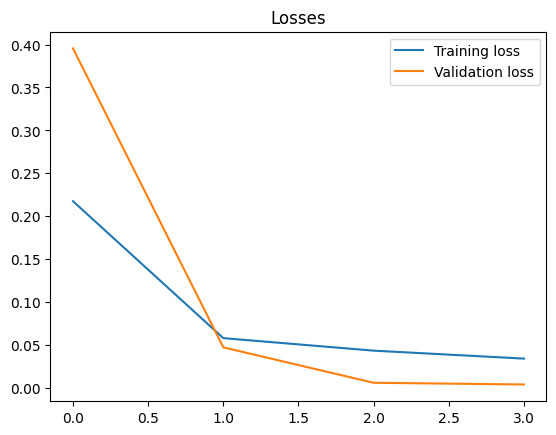

PRED: [190.20074 188.06245 193.17548 196.69368 189.07779 192.51093 197.4797
 194.4366  193.54161 200.87628 195.15819 193.22343]
REAL: [188.80437 192.83313 192.20369 194.78844 190.66109 190.3997  192.2271
 191.29836 187.32166 192.0135  189.2994  191.61847]
{'mae': 3.6396625, 'rmse': 4.357217890787966}


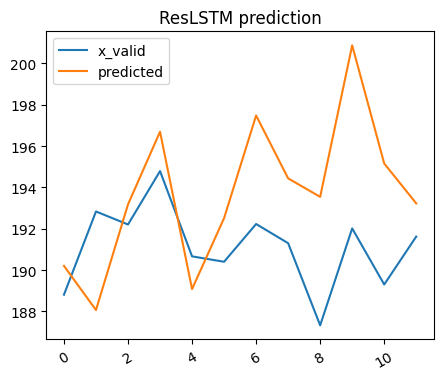

{'mae': 3.6396625, 'rmse': 4.357217890787966}


In [ ]:
batch_size = 8
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 128
layer_dim = 1
layers_count = 6
dropout = 0.1
n_epochs = 4
learning_rate = 0.0006
weight_decay = 1e-6

# input_dim, hidden_dim, shortcut_layer_dim, layers_count, output_dim, dropout_prob

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                "layers_count" : layers_count, 
                'output_dim' : output_dim,
                'dropout_prob' : dropout
                }

model = ResLSTMModel(**model_params)

loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.HuberLoss(delta=1.1)
# loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()
predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)

df_result = format_predictions(predictions, values, X_test, None)
result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ResLSTM prediction")
plt.show()

result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Ensembles

In [ ]:
batch_size = 16
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

## Residual LSTM

In [ ]:
X, y, div = createDataset(df, 24, output_dim)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
batch_size = 8
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
dropout = 0.1
n_epochs = 5
learning_rate = 0.0006
weight_decay = 1e-6

loss_fn = nn.MSELoss(reduction="mean")
# loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
models = []
layer_props = (96, 1, 4)
for i in range(10):
  hidden_dim, layer_dim, layers_count = layer_props
  model_params = {
    'input_dim': input_dim,
    'hidden_dim' : hidden_dim,
    'layer_dim' : layer_dim,
    "layers_count" : layers_count, 
    'output_dim' : output_dim,
    'dropout_prob' : dropout
  }
  model = ResLSTMModel(**model_params)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
  models.append(opt)
  print(f"Trained model with h={hidden_dim} l={layer_dim}")

Creating Residual LSTM model 24 96 1 4 12 0.1
Creating Residual LSTM 96 96 1 0.1
Creating Residual LSTM 96 96 1 0.1
Creating Residual LSTM 96 96 1 0.1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


[1/5] Training loss: 0.2214	 Validation loss: 0.5109
[2/5] Training loss: 0.0982	 Validation loss: 0.1845
[3/5] Training loss: 0.0452	 Validation loss: 0.0398
[4/5] Training loss: 0.0455	 Validation loss: 0.0164
[5/5] Training loss: 0.0337	 Validation loss: 0.0071
Trained model with h=96 l=1
Creating Residual LSTM model 24 96 1 4 12 0.1
Creating Residual LSTM 96 96 1 0.1
Creating Residual LSTM 96 96 1 0.1
Creating Residual LSTM 96 96 1 0.1
[1/5] Training loss: 0.2519	 Validation loss: 0.5771
[2/5] Training loss: 0.1215	 Validation loss: 0.2309
[3/5] Training loss: 0.0450	 Validation loss: 0.0421
[4/5] Training loss: 0.0424	 Validation loss: 0.0114
[5/5] Training loss: 0.0333	 Validation loss: 0.0052
Trained model with h=96 l=1
Creating Residual LSTM model 24 96 1 4 12 0.1
Creating Residual LSTM 96 96 1 0.1
Creating Residual LSTM 96 96 1 0.1
Creating Residual LSTM 96 96 1 0.1
[1/5] Training loss: 0.2285	 Validation loss: 0.5160
[2/5] Training loss: 0.1005	 Validation loss: 0.1783
[3/5] 

models count in stack: 10
[1/5] Training loss: 0.1338	 Validation loss: 0.1424
[2/5] Training loss: 0.0181	 Validation loss: 0.0056
[3/5] Training loss: 0.0237	 Validation loss: 0.0035
[4/5] Training loss: 0.0261	 Validation loss: 0.0039
[5/5] Training loss: 0.0253	 Validation loss: 0.0037


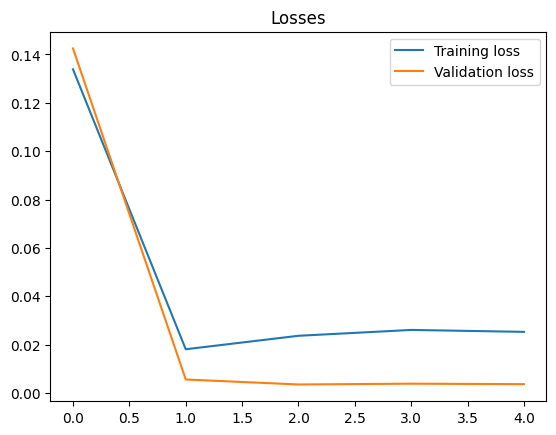

PRED: [184.59172 183.81357 185.06967 184.08482 188.3105  187.73709 187.8472
 190.47287 190.52998 189.51385 191.19624 192.51372]
REAL: [188.80437 192.83313 192.20369 194.78844 190.66109 190.3997  192.2271
 191.29836 187.32166 192.0135  189.2994  191.61847]
{'mae': 4.1490417, 'rmse': 5.14766334189307}


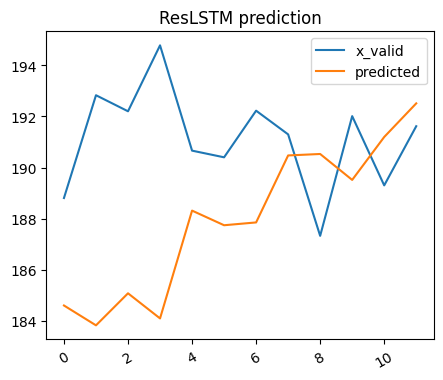

In [ ]:
def disable_grad(layer):
    for _layer in layer.layers:
      for p in _layer.parameters():
          p.requires_grad=False
    for p in layer.parameters():
          p.requires_grad=False
    return layer

learning_rate = 0.0001
model = Stack(list(map(lambda x: x.model, models)), 512, output_dim, disable_grad)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=5, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)

df_result = format_predictions(predictions, values, X_test, None)
result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ResLSTM prediction")
plt.show()

## Basic LSTM

In [ ]:
X, y, div = createDataset(df, 36, output_dim)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y, 0.2)
batch_size = 8
train_loader, val_loader = createTrainers(X_train.values, y_train.values, X_val.values, y_val.values, batch_size)

input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
dropout = 0.1
n_epochs = 9
learning_rate = 0.0006
weight_decay = 1e-6

loss_fn = nn.HuberLoss(reduction='mean', delta=1.0)
models = []
layer_props = (96, 3, 3)
for i in range(8):
  hidden_dim, layer_dim, layers_count = layer_props
  model_params = {
    'input_dim': input_dim,
    'hidden_dim' : hidden_dim,
    'layer_dim' : layer_dim,
    # "layers_count" : layers_count, 
    'output_dim' : output_dim,
    'dropout_prob' : dropout
  }
  model = LSTMModel(**model_params)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
  opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
  models.append(opt)
  print(f"Trained model with h={hidden_dim} l={layer_dim}")

[1/9] Training loss: 0.1351	 Validation loss: 0.2943
[2/9] Training loss: 0.0403	 Validation loss: 0.0171
[3/9] Training loss: 0.0161	 Validation loss: 0.0025
[4/9] Training loss: 0.0122	 Validation loss: 0.0180
[5/9] Training loss: 0.0090	 Validation loss: 0.0056
[6/9] Training loss: 0.0088	 Validation loss: 0.0113
[7/9] Training loss: 0.0073	 Validation loss: 0.0053
[8/9] Training loss: 0.0073	 Validation loss: 0.0096
[9/9] Training loss: 0.0064	 Validation loss: 0.0054
Trained model with h=96 l=3
[1/9] Training loss: 0.1453	 Validation loss: 0.3079
[2/9] Training loss: 0.0439	 Validation loss: 0.0239
[3/9] Training loss: 0.0153	 Validation loss: 0.0032
[4/9] Training loss: 0.0111	 Validation loss: 0.0152
[5/9] Training loss: 0.0082	 Validation loss: 0.0062
[6/9] Training loss: 0.0080	 Validation loss: 0.0107
[7/9] Training loss: 0.0068	 Validation loss: 0.0063
[8/9] Training loss: 0.0070	 Validation loss: 0.0080
[9/9] Training loss: 0.0062	 Validation loss: 0.0059
Trained model with

models count in stack: 8
[1/4] Training loss: 0.1866	 Validation loss: 0.3084
[2/4] Training loss: 0.0730	 Validation loss: 0.0969
[3/4] Training loss: 0.0249	 Validation loss: 0.0196
[4/4] Training loss: 0.0101	 Validation loss: 0.0048


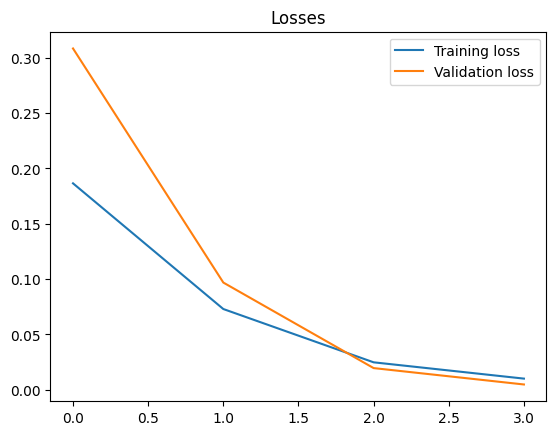

PRED: [198.8015  188.4327  198.26363 196.35753 200.83421 194.69458 197.80196
 202.3158  190.20334 203.80151 182.50302 191.01033]
REAL: [188.80437 192.83313 192.20369 194.78844 190.66109 190.3997  192.2271
 191.29836 187.32166 192.0135  189.2994  191.61847]
{'mae': 6.2634254, 'rmse': 7.22677127021074}


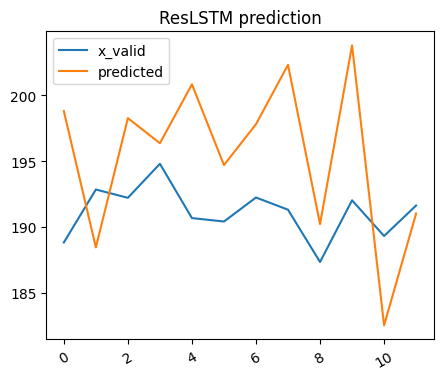

In [ ]:
def disable_grad(layer):
    for p in layer.parameters():
          p.requires_grad=False
    return layer

learning_rate = 0.00006
model = Stack(list(map(lambda x: x.model, models)), 512, output_dim, disable_grad)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Trainer(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=4, n_features=input_dim)
opt.plot_losses()

predictions, values = opt.evaluateFromArrays(X_test, y_test, n_features=input_dim)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).squeeze() # np.exp(predictions) # *div[-1]
values = scaler.inverse_transform(values.reshape(-1, 1)).squeeze() # np.exp(values) # *div[-1]
print("PRED:", predictions)
print("REAL:", values)

df_result = format_predictions(predictions, values, X_test, None)
result_metrics = calculate_metrics(df_result)
print(result_metrics)

# Plot
plt.figure(figsize=(5, 4))
plt.plot(values, label = 'x_valid')
plt.plot(predictions, label = 'predicted')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.legend()
plt.title("ResLSTM prediction")
plt.show()

# Summary

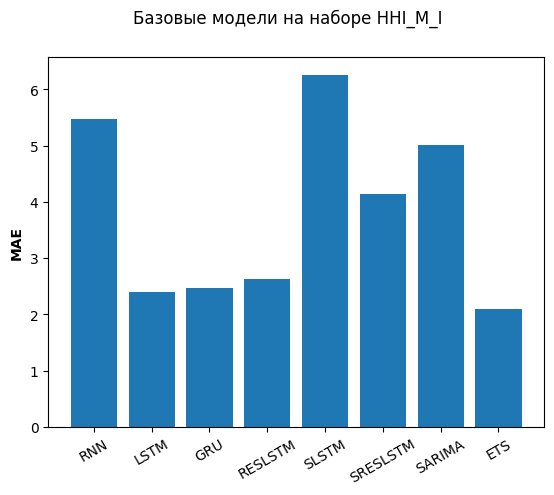

In [ ]:
yt = [5.47, 2.4, 2.471, 2.636, 6.263, 4.149, 5.0157, 2.099]

xt = [r for r in range(len(yt))]

xlabels =  ['RNN', 'LSTM', 'GRU', 'RESLSTM', 'SLSTM', 'SRESLSTM', 'SARIMA', 'ETS']

plt.bar(xt, yt)
plt.xticks(xt, xlabels[: len(yt)])
plt.ylabel('MAE', fontweight ='bold')
plt.tick_params(axis = 'x', labelrotation = 30)

plt.suptitle('Базовые модели на наборе HHI_M_I')

plt.show()